In [216]:
import urllib.request as urllib2
import urllib
import re
import json
import pandas as pd
import numpy as np
import os
import mwparserfromhell
import pickle
import re
import networkx as nx
import pandas as pd
import numpy as np
from numpy import mean
import os
from collections import Counter
import pickle
from fa2 import ForceAtlas2
import matplotlib.pyplot as plt
import random
import seaborn as sns
import collections
import operator
from operator import itemgetter
from wordcloud import WordCloud
from infomap import Infomap
import nltk, re, pprint
from nltk import word_tokenize
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import community
import matplotlib as mtpl
import copy
import math
import csv
from webweb import Web # pip install webweb
import random, os, math, pickle, itertools, nltk, re, pprint, pandas as pd, numpy as np, copy, seaborn as sns, matplotlib.pyplot as plt

%matplotlib inline

<a id='2-1-stats'></a>
## 2.1 Write about your choices in the data cleaning and preprocessing

<a id='2-1-1-wikis'></a>
### 2.1.1 Wikis

Data cleaning and preprocessing for the Wikipages was a vital but long and strenuous effort. As with any text and website data, there was a certain degree of noise and difficulties determining meaningful attributes. 

This chapter offers brief descriptions of the process of getting the data in a usable state, but will not go in to details. For the full experience, please refer to [Appendix 6.2. - Fandom Wikipages - Data fetching and cleaning](#6-2-wiki-cleaning), if you find this sort of effort enjoyable.

Here, let's jump ahead to the end result:

In [12]:
# Fetching dataframes to support text

hd = os.getcwd()

# Fetching the wikipages dataframes for comparison

with open(hd + '/Wikis/dataframes/original_wiki_df.pkl', 'rb') as f:
    df_wiki_original = pickle.load(f)

with open(hd + '/Wikis/dataframes/cleaned_wiki_df.pkl', 'rb') as f:
    df_wiki_cleaned = pickle.load(f)

**Data fetching**

The Fandom WikiPages are readily accessible through API calls to their server. This being said, it not strictly plug-and-play in terms of fetching the data, and it is not immediately obvious what to fetch. 

**Fetching of links**

After thorough inspection of the [Harry Potter Fandom website](https://harrypotter.fandom.com/wiki/Main_Page), it was discovered that the data should be fetched in the following way - Note that this step only stores the links to the actual character pages, which we want to build a network later: 

* Use the base url:
_'harrypotter.fandom.com/api.php?action=query&prop=revisions&rvprop=content&rvslots=main&format=json&utf8=1&titles='_

* And for each book, call the API with the book's corresponding link, asking for the character index, example: '_Harry_Potter_and_the_Philosopher%27s_Stone(character_index)_'

* Use regular expressions to fetch the links to the characters on the page (They are enclosed in '[ ]' notation) and store them


Once we have the links to the character pages, the dataframe looks like this: 

In [14]:
df_wiki_original.head(3)

wiki  book alternative_wiki
0                                     Tufty     1             None
1                          Mirror of Erised     1             None
2  Quirinus Quirrell's first mountain troll     1             None

It looks like now we have a "wiki" (looks like a character name) and book number that character first appeared in. At this stage it was decided to add a third column 'alternative_wiki', to handle the case where a character has two different pages for a variety of reasons. Some duplicates existed and were dropped, and the data size was as follows:

The dataframe length before dropping duplicates was: **810**

The dataframe length after dropping duplicates was: **789**

Some MSc-level mathematics reveals that this adds up to 21 duplicates removed. 


**Fetching of character pages**

Now that we have the different Wiki links for the different characters, we are ready to go through this dataframe and populate our data with the Wikipages. But you might have rightly noticed that these wiki 'links' are merely names, and as such we used the handy [Urllib](https://docs.python.org/3/library/urllib.html) library to parse the links. 

Again, this description should not be overly verbose, but if you read through the Appendix, you can get the picture. We started by calling the APIs for the different character pages, and attempting to parse the response in to JSON format. Through this, we could be assured that the reply we were processing would follow our expectations. At this stage, _redirects_ had to be handled as well, as some of the links pointed us to a different page. Thankfully, Fandom includes a handy _#REDIRECT_ flag on this occurrance, so it did not prove too problematic. Each of the pages were fetched successfully and stored in text files, split in to folders by the books that the WikiPage was part of, for example:

* Book1 -> Harry Potter.txt
* Book2 -> Dobby.txt
* ...

At this point we were readily set for cleaning and extraction of meaningful attributes.


**Extraction and cleaning of the character pages**

We then looped through the text files that we had created (remember, 1 for each character), and did the following:

* Parsed the text in to _templates_ using the handy [MyParserFromHell](https://pypi.org/project/mwparserfromhell/) library.

* Scanned the page for links to other pages using regular expression (again, the '[ ]' notation was useful)

* Scanned the templates for valuable keywords that were found through extensive trial-and-error

* Labelled different attributes according to the findings


Again, we won't go in to too much detail here, but these are the attributes in question:

* Hogwarts House
* Wiki type (not just individuals, also spells, pets etc.)
* Gender (if applicable)
* Nationality
* Species
* Hair
* Eye colour
* (Magical) blood type


This data is not always available, and some decisions had to be made in regards to the sorting in to these attributes. A lot of manual clustering was done (see Appendix), but the following is the most important decision that requires explanation:

**Blood type** was a messy attribute. It often included many different blood types, as is further discussed in the Appendix. After visual inspection of the variables it was decided to simplify the data using the following logic:

If the blood type included the following keywords (in this priority order), then that was determined to be the attribute of the node:

* **"Half-Blood"** if attribute includes "half-blood" 
* **"Pure-Blood"** if attribute includes "pure-blood" 
* **"Muggle"** if attribute includes "non-magic people|muggle" 
* **"Muggle-Born"** if attribute includes "muggle-born"
* **"Unknown** otherwise

This was an important decision but a necessary one, and as such might have impacted the data in small ways through mislabelings. This logical ordering, however, seemed to produce the most sensible results.

Let's see how the data looked at this point:





In [17]:
df_wiki_cleaned.sample(3)

wiki  book alternative_wiki  \
488       Rose Zeller     5             None   
0               Tufty     1             None   
110  Angelina Johnson     1             None   

                                                  text  \
488  individual rose september august school witchc...   
0    pet individual arabella figg tufty one arabell...   
110  wife george captain gryffindor quidditch team ...   

                                                 links       house  \
488                                       [Wizardkind]  Hufflepuff   
0    [Dudley Dursley, Mr Tibbles, Harry Potter, Sno...     Unknown   
110  [Neville Longbottom, George Weasley, Molly Wea...  Gryffindor   

           type    blood nationality  gender     hair     eyes  species  
488  Individual  Unknown     Unknown  Female  Unknown  Unknown    Human  
0           Pet  Unknown     Unknown    Male  Unknown  Unknown  Unknown  
110  Individual  Unknown     Unknown  Female  Unknown  Unknown    Human

**Looks ready enough!**

These attributes provided us with some interesting insights in to the different characters in the data. Most importantly, however, we now had a list of other characters that each character had a reference to on their page, allowing us to build a network and populate it with these nodes. 


---

<a id='2-2-stats'></a>
## 2.2 Write a short section that discusses the dataset stats (here you can recycle the work you did for Project Assignment A)

<a id='2-2-1-wikis'></a>
### 2.2.1 Wikis

Write a short section that discusses the dataset stats (here you can recycle the work you did for Project Assignment A)

As already described in chapter [2.1.1 (data cleaning and preprocessing)](#2-1-1-wikis), different text files of the WikiPages were generated (1 for each Wikipage). The count of these WikiPages was **789**, and the files weighed a total of around **11 Megabytes**. 

Not all of the Wikis were unique, but **788** were used to build the network. The attributes included in the WikiPages dataset include the aforementioned:

* Hogwarts house
* Species
* Magical blood type 
* ...

For an analysis on the distributions of these different attributes in the network, please refer to the 'Attribute Statistics' part of chapter [3.1.1 (data cleaning and preprocessing)](#3-1-1-networkcreation). Additinoally, information on the links between Wikipages is analysed in the 'Degree distribution analysis' part of the same chapter.

788


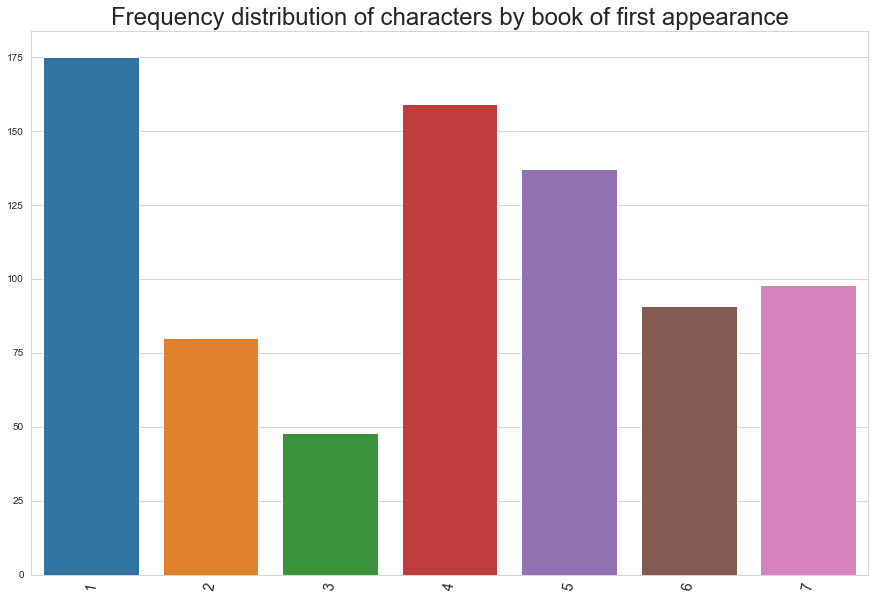

In [28]:
# Setting style
sns.set_style("whitegrid")

# Getting the types of WikiPages in the network
books = [book for (book) in df_wiki_cleaned['book']]

# Sorting the values by frequency
book_frequs = {key: value for key, value in sorted(collections.Counter(books).items(), 
                                             key=lambda item: item[1], reverse=True)}
# Preparing figure
plt.figure(figsize=(15,10))

# Plotting Wiki types
fig = sns.barplot(
    x = list(book_frequs.keys()),
    y = list(book_frequs.values())
)

plt.xticks(rotation=80, size=14)

plt.title("Frequency distribution of characters by book of first appearance", 
              fontdict = {'fontsize' : 24})

plt.show()

The figure above represents the distribution of which book the Wikipages were corresponding to. Perhaps unsurprisingly, book 1 has the highest number of first appearances, but book 4 and 5 seem to shake things up considerably in the Harry Potter universe. Noticably low is book 3 (Prisoner of Azkaban) with less than 50 characters.

All the WikiPages have a book associated with them, but this is not the case with all attributes. Hogwarts house, blood type and others are sadly missing on a lot of pages. For details on this, refer to [3.1.1](#3-1-1-networkcreation).

---

<a id='tools'></a>
# 3. Tools, theory and analysis. Describe the process of theory to insight
* **Talk about how you've worked with the text, including regular expressions, unicode, etc.**
* **Describe which network science tools and data analysis strategies you've used, how those network science measures work, and why the tools you've chosen are right for the problem you are solving.**
* **How did you use the tools to understand your dataset?**

<font color='red'>
Setup:

* Explain the overall idea
* Analysis step 1
    * Explain what you're interested in
    * Explain the tool
    * apply the tool
    * Discuss the outcome
* Analysis step 2
    * Explain what you're interested in
    * Explain the tool
    * apply the tool
    * Discuss the outcome
* Analysis step 3
    * Explain what you're interested in
    * Explain the tool
    * apply the tool
    * Discuss the outcome


<a id='3-2-books'></a>
## 3.1 Fandom Wikis

For the Wiki pages, a series of analyses were performed. Here, an outline of what was done with the pages in terms of network analyses is outlined. The chapter is split up in to a few different parts, with varying complexity and length. A short introduction is presented at the beginning of each part of analysis, and a short summary at its end.

The overall idea is to use the text in the WikiPage documents to construct a network out of the references the WikiPages have to each other. Then, analyses on the degrees, statistics on the attributes in the network, community detection and sentiment analysis are performed. Finally, an interactive version of some (sub) networks are created.


* [3.1.0 Wiki analysis setup and preparation](#3-1-0-preparation)
* [3.1.1 Wiki network creation and visualizations](#3-1-1-networkcreation)
* [3.1.2 Wiki network analyses](#3-1-2-networkanalyses)
* [3.1.3 Wiki network community detection](#3-1-3-networkcommunitydetection)
* [3.1.4 Wiki page sentiment analysis](#3-1-4-networksentiments)
* [3.1.5 (Bonus) Interactive Wiki network](#3-1-5-interactivenetwork)





<a id='3-1-0-preparation'></a>
### 3.1.0 Wiki analysis setup and preparation

Here we have to fetched the cleaned dataframe that included all the attributes for the network. Some functions to assist analyses are defined and text cleaning is outlined. 

Here, we mostly use Python, Pandas, the [ForceAtlas2 algorithm](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0098679) for node positioning, and the [Natural Language Toolkit (NLTK)](https://www.nltk.org/) package for text cleaning.



In [29]:
# Defining home directory

hd = os.getcwd()

# Fetching the WikiPage dataframe

with open(hd + '/Wikis/dataframes/cleaned_wiki_df.pkl', 'rb') as f:
    df_wiki = pickle.load(f)
    
df_wiki.head(2)

wiki  book alternative_wiki  \
0             Tufty     1             None   
1  Mirror of Erised     1             None   

                                                text  \
0  pet individual arabella figg tufty one arabell...   
1  mirror storage dungeon room requirement hogwar...   

                                               links    house    type  \
0  [Dudley Dursley, Mr Tibbles, Harry Potter, Sno...  Unknown     Pet   
1  [Aberforth Dumbledore, Boggart, Gregory Goyle,...  Unknown  Object   

     blood nationality gender     hair     eyes  species  
0  Unknown     Unknown   Male  Unknown  Unknown  Unknown  
1  Unknown     Unknown   Male  Unknown  Unknown  Unknown

You might have correctly noticed that the 'text' attribute does not look very Wiki-page-like. This is because it has been cleaned, but more on that in section [3.1.0](#3-1-0-preparation).


**Defining functions and objects for visualizations**

The following cells are for configuration purposes and analyses later on.

In [30]:
# Getting the ForceAtlas algorithm configuration ready

forceatlas2 = ForceAtlas2(
    # Behavior alternatives
    outboundAttractionDistribution = False, # Dissuade hubs
    edgeWeightInfluence=1,
    
    # Performance
    jitterTolerance=0.2, # Tolerance
    barnesHutOptimize=True,
    barnesHutTheta=0.6,
    
    # Tuning
    scalingRatio=5,
    strongGravityMode=True,
    gravity=1.0,
    
    # Log
    verbose=False
)

In [31]:
# For plotting in- and out-degree distributions. 

def display_histogram_and_loglog_distributions(G_type, print_str, title, bins):
    # Function that displays histogram and log-log of network side-by-side.
    # Takes in network type, print string, title, and number of bins for histogram
    # Typically gets (G.in_degree() or G.out_degree())
    
    degs = [deg for (node, deg) in G_type]
    hist, bin_edges = np.histogram(degs, bins=bins)
    degree_sequence = sorted([d for n, d in G_type], reverse=True)
    degreeCount = Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())

    fig, axs = plt.subplots(1, 2,figsize=(15,5)) # Side-by-side comparison
    fig.suptitle(title, size=18)
    
    axs[0].hist(degs, bin_edges) # Histogram plot
    axs[0].set(ylabel='Frequency', xlabel='Degree')
    axs[0].set_title('Histogram of the {} distribution'.format(print_str)) # Setting a dynamic title    
    axs[1].loglog(bin_edges[:-1], hist, 'bo', markersize=4) # Log-log plot
    axs[1].set_title('Log-log of the {} distribution'.format(print_str))
    axs[1].set(ylabel='Frequency', xlabel='Degree');
    
    plt.show()
    
def make_scatter_plots(G, with_percentiles = False, equalize_y_axis = False):
    # A function that makes side-by-side scatterplots of in-degree and out-degree distributions
    # Takes in Network and two booleans, self-explanatory
    
    node_indices = [i for i in range(len(G.nodes))] # indices
    nodes = [node for node in G.nodes] # all nodes in network

    in_degrees = [G.in_degree(node) for node in nodes] # All in-degree values
    out_degrees = [G.out_degree(node) for node in nodes] # All out-degree values
    
    all_degrees = in_degrees + out_degrees # All degrees to find max
    
    y_axis_max = max(all_degrees) # For y axis equalization
    
    fig, axs = plt.subplots(1, 2,figsize=(15,5)) 
    
    axs[0].scatter(node_indices, in_degrees, s=2) # In-degree scatter
    axs[0].set_xlabel('Network nodes (no particular order)')
    axs[0].set_ylabel('In degree')
    axs[0].set_title('In-degree scatter plot of the network')
    if(equalize_y_axis):
        axs[0].set_ylim(0, y_axis_max)
    
    axs[1].scatter(node_indices, out_degrees, s=2) # Out-degree scatter
    axs[1].set_xlabel('Network nodes (no particular order)')
    axs[1].set_ylabel('Out degree')
    axs[1].set_title('Out-degree scatter plot of the network')
    if(equalize_y_axis):
        axs[1].set_ylim(0, y_axis_max)

    if with_percentiles:
        # If percentile lines were requested
        
        percentiles = [95, 99, 99.7] # Defining three high percentiles to explore

        colours = ["#264653", "#e9c46a", "#e76f51"] # And their colours
        
        # Drawing line for each percentile on each graph
        for i in range(len(percentiles)):    
            axs[0].axhline(y=np.percentile(in_degrees, percentiles[i]), c=colours[i], xmin=0, xmax=1, alpha=0.9, label=str(percentiles[i])+"th pct")
            axs[1].axhline(y=np.percentile(out_degrees, percentiles[i]), c=colours[i], xmin=0, xmax=1, alpha=0.9, label=str(percentiles[i])+"th pct")
            axs[0].legend()
            axs[1].legend()

    return axs

def plot_scatter_with_labels_over_percentile(degs, print_str, title, percentile):
    fig=plt.figure(figsize=(8,5))
    ax=fig.add_axes([0,0,1,1])
    ax.scatter(node_indices, degs, s=[degree / 25 for degree in degs], c=degs, cmap="Blues") # Size map included
    ax.set_xlabel('Network nodes (random order)')
    ax.set_ylabel(print_str)
    #ax.set_ylabel('In degree')
    ax.set_title(title)
    #ax.set_title('In-degree scatter plot of the network (over 99.7th percentile)')

    # Adding the horizontal line for the 99.7th percentile
    plt.axhline(y=np.percentile(degs, percentile), xmin=0, xmax=1, alpha=0.7, label="{}th pct".format(percentile))   

    # And annotating the top degrees
    for n in range(len(degs)):
        if degs[n] > np.percentile(degs, percentile):
            plt.text(n+10, degs[n], nodes[n], fontsize=9)
    
    plt.legend()        
    plt.show()

**Cleaning of Wiki Page text**

After extracting the links and attributes out of the WikiPages, a decision was made to tokenize and lemmatize the text. This means that words were cut down to its root, and the text was split up by whitespaces or punctuation and other symbols were removed. Some manual forbidden words were defined 'www', 'category', 'file', and each word was lowercased. For the step-by-step of this, see  [Appendix 6.2. - Fandom Wikipages - Data fetching and cleaning](#6-2-wiki-cleaning).

As such, the _'wiki_text'_ attribute in the network contains a cleaned text at this point. This was done in order to make the sentiment- and word analyses easier later on.

<a id='3-1-1-networkcreation'></a>


### 3.1.1 Wiki network creation and visualization

Here, we want to create an actual network out of the Wikipage data. This requires us to create nodes from the individual rows and edges from the corresponding 'links' attribute. This indicates that a node refers to another node in their WikiPages.

Initially, a Directed Graph is useful here for network analysis. This allows for the analyses of node degree distributions, which may reveal a scale-free property. For many visualizations, an undirected graph (of the same network) is opted for instead. 

For the network creation, the NetworkX library is very handy. It utilizes a series of Python libraries and provides all of the needed out-of-the-box functionality for network creation and analysis. Here, we use NetworkX to construct a directed graph from the links in the Wiki data. For visualization, we use the ForceAtlas2 algorithm for positioning, and Matplotlib do display graphs.

In [32]:
G = nx.DiGraph()

# Add all the edges to the graph
for idx, row in df_wiki.iterrows():
    G.add_node(row.wiki, # node name
                book_nr = row.book, 
                house = row.house, 
                node_type = row.type, 
                links = row.links, 
                wiki_text = row.text,
                blood = row.blood,
                gender = row.gender,
                hair = row.hair,
                eyes = row.eyes,
                species = row.species,
                nationality = row.nationality
               )
    
        
print("Added {} nodes. Size of network: {}".format(len(df_wiki), len(G)))  

Added 788 nodes. Size of network: 788


_And then adding the edges:_

In [33]:
for idx, row in df_wiki[pd.notna(df_wiki.links)].iterrows():
    for link in row['links']:
        if link in G: # If other entity is in the network
            G.add_edge(row.wiki, link)
            
print("{} edges in network.".format(len(G.edges)))

12389 edges in network.


Now that we have the entire WikiPage network loaded up, let's see how it looks raw:

In [34]:
# Getting positions for the network nodes

positions = forceatlas2.forceatlas2_networkx_layout(G, 
                                                    pos=None, 
                                                    iterations=2000);

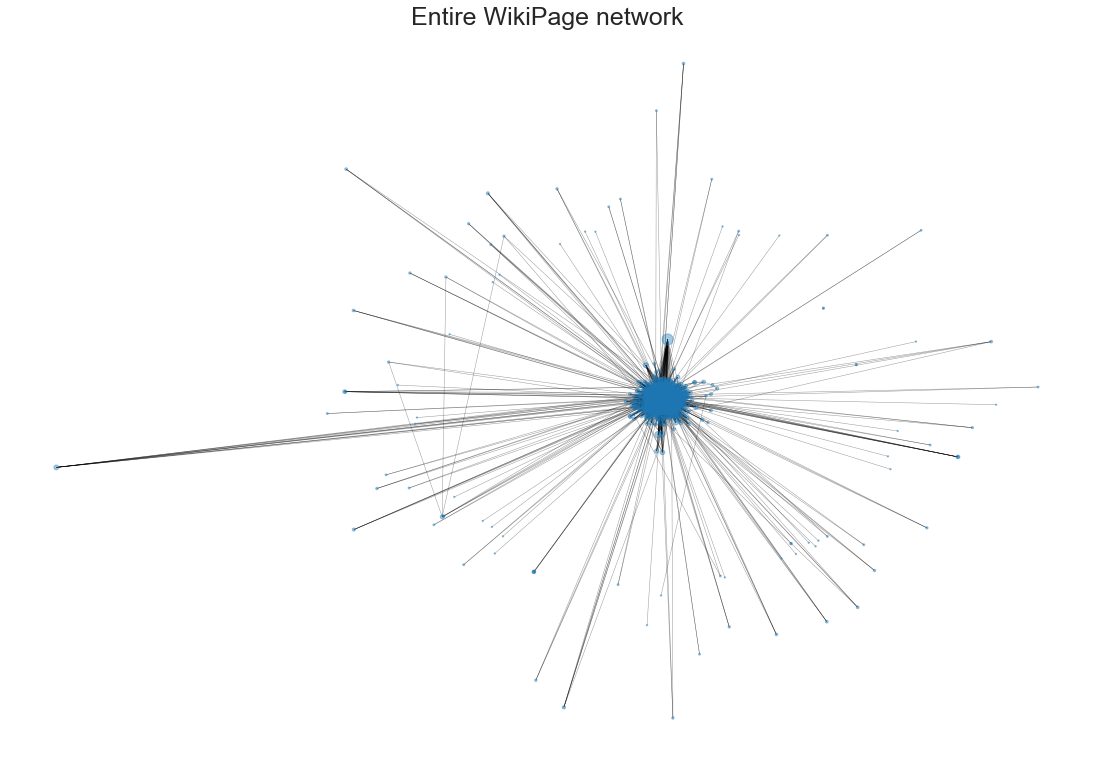

In [35]:
# Determining node sizes: 
node_sizes = [val*1500 for val in nx.degree_centrality(G).values()] 

# And we're ready to visualise:

plt.figure(figsize=(15,10))

nx.draw(nx.to_undirected(G), 
        positions, 
        with_labels = False, 
        node_size = node_sizes, 
        width=0.5, 
        alpha=0.4);

plt.title("Entire WikiPage network", fontsize=25, ha='center')
plt.show()

The entire WikiNetwork is clearly very sparse (has many nodes that have few degrees) and the visualization is not very meaningful. The network clearly needs work before anything concrete can be interpreted visually. We will fix this later on. In the meantime, let's visualize only the nodes with at least 4 in-degree (other nodes pointing to the node) and 4 out-degree (pointing to other nodes):

In [36]:
min_connectivity = 4
highly_connected_nodes = [node for node in G.nodes if G.in_degree[node] >= min_connectivity and G.out_degree[node] >= min_connectivity]

G_high = G.subgraph(highly_connected_nodes)

print("Size of new highly connected subgraph: {}".format(len(G_high)))

Size of new highly connected subgraph: 377


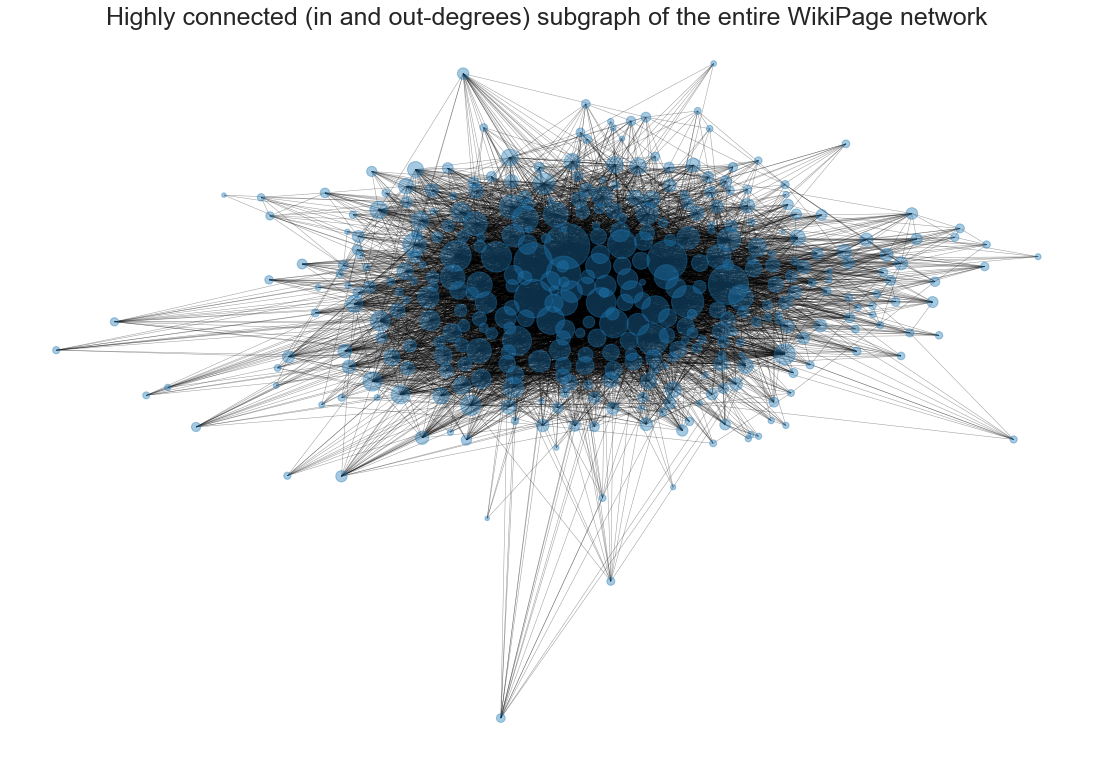

In [37]:
# Getting positions for the network nodes

positions_subgraph = forceatlas2.forceatlas2_networkx_layout(G_high, 
                                                    pos=None, 
                                                    iterations=2000);

# Determining node sizes: 
node_sizes = [val*1500 for val in nx.degree_centrality(G_high).values()] 

# And we're ready to visualise:

plt.figure(figsize=(15,10))

nx.draw(nx.to_undirected(G_high), 
        positions, 
        with_labels = False, 
        node_size = node_sizes, 
        width=0.5, 
        alpha=0.4);

plt.title("Highly connected (in and out-degrees) subgraph of the entire WikiPage network", fontsize=25, ha='center')
plt.show()

That looks more revealing. The network seems to include a giant component, but we'll get to that later. Now let's explore what kind of nodes the network holds.

**Let's visualize the different types of nodes in the data:**

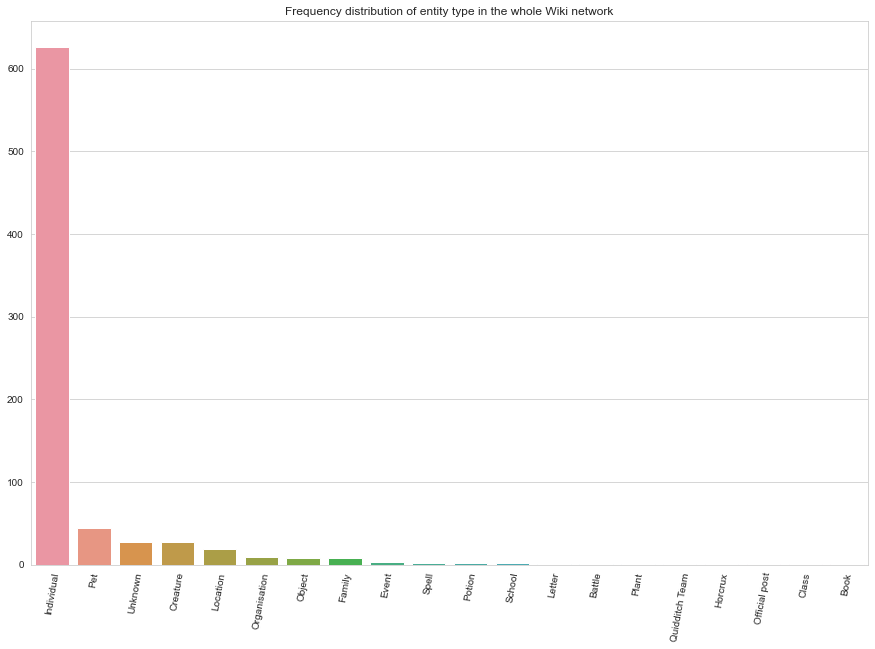

In [38]:
# Setting style
sns.set_style("whitegrid")

# Getting the types of WikiPages in the network
entity_types = [wiki_type for (node, wiki_type) in G.nodes.data('node_type')]

# Sorting the values by frequency
types = {key: value for key, value in sorted(collections.Counter(entity_types).items(), 
                                             key=lambda item: item[1], reverse=True)}

# Preparing figure
plt.figure(figsize=(15,10))

# Plotting Wiki types
fig = sns.barplot(
    x = list(types.keys()),
    y = list(types.values())
)

plt.title("Frequency distribution of entity type in the whole Wiki network")
plt.xticks(rotation=80)

plt.show()

It would appear that thankfully, mostly our network consists of Individuals, with Pets following after that. This is good, because we're only interested in individuals for the remaining network analyses. 

But before we clean out the non-individual nodes, let's check the degree distributions on the whole network:

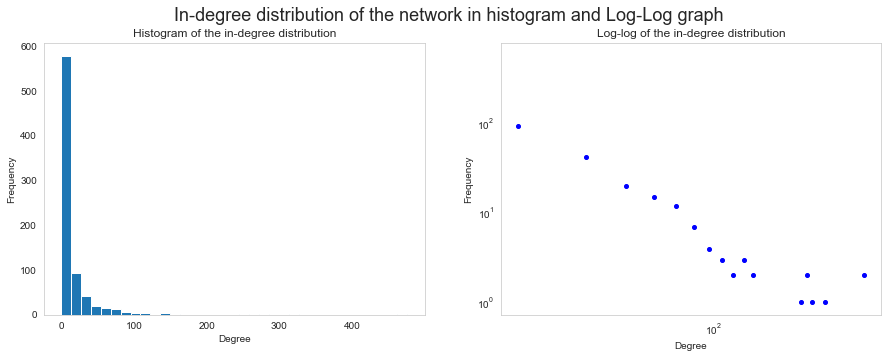

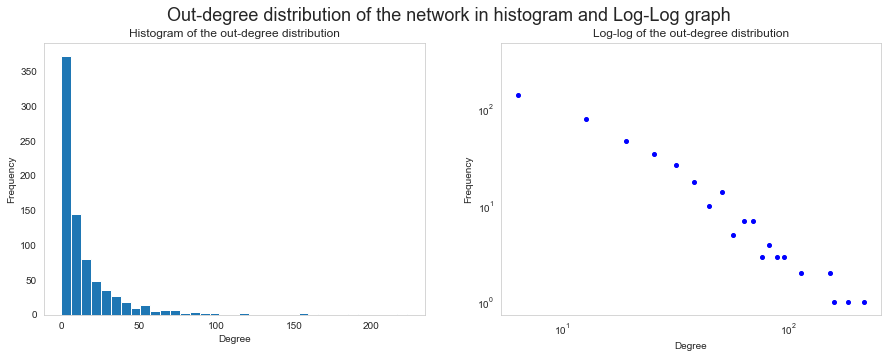

In [40]:
# Calling the predefined distribution visualisation functions

display_histogram_and_loglog_distributions(G_type=G.in_degree(), #Plotting the in-degree distribution
                                           bins=35, 
                                           print_str="in-degree", 
                                           title="In-degree distribution of the network in histogram and Log-Log graph")

display_histogram_and_loglog_distributions(G_type=G.out_degree(), # Plotting the out-degree distribution
                                           bins=35, 
                                           print_str="out-degree", 
                                           title="Out-degree distribution of the network in histogram and Log-Log graph")


The above figures show the in-degree and out-degree distributions of the whole Wiki network. Note the substantial amount of nodes around 0 on the in-degree graph, and how far to the right it stretches. This could indicate that the network has hubs (nodes with disproportionally high in-degree).

We will revisit this analysis later for the individual nodes only.

Let's check the highest in-degree nodes in this whole network and see whether they're individuals

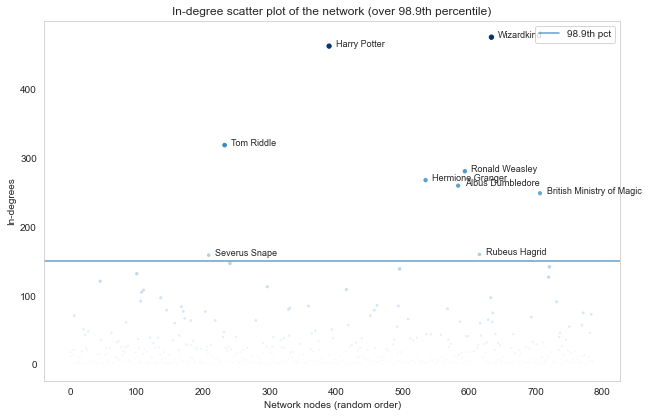

In [39]:
# Checking the highest in-degree nodes in the whole network

sns.set_style("whitegrid", {'axes.grid' : False})

nodes = [node for node in G.nodes] # for this we need all nodes in network
node_indices = [i for i in range(len(G.nodes))] # indices

random.shuffle(nodes) # randomising the list for ordering (with same seed)

in_degrees = [G.in_degree(node) for node in nodes] # All in-degree values
out_degrees = [G.out_degree(node) for node in nodes] # All out-degree values

plot_scatter_with_labels_over_percentile(in_degrees, 
                                         "In-degrees", # Axis string
                                         "In-degree scatter plot of the network (over 98.9th percentile)", # Plot title 
                                         98.9 # percentile
                                         )

plt.show()

Notice above that even though our beloved Harry Potter characters populate the highest in-degree visualisation, the highest node is **Wizardkind**. Additionally, the **British Ministry of Magic** is included among the highest in-degree nodes. 

Although analyses could be interesting on a network like this, we need to change the network in such a way that only individuals are included:

**Now, let's determine the nodes that don't represent individuals:**

In [41]:
# Finding all nodes that aren't actual individuals
non_individual_nodes = [node for node in G.nodes if not G.nodes[node]['node_type'] == "Individual"] 

print("Size of entire Wiki network: {}".format(len(G)))

G.remove_nodes_from(non_individual_nodes)

print("Size of Wiki network after deletion of non-individuals: {}".format(len(G)))

Size of entire Wiki network: 788
Size of Wiki network after deletion of non-individuals: 626


The network now only consists of nodes that represent individuals. Now let's visualize this network much like we did previously, but now we can add colors representing node attributes!

Additionally, we're setting the minimum in- and out-degrees (here 'connectivity') as 3.

In [42]:
min_connectivity = 3
highly_connected_nodes = [node for node in G.nodes if G.in_degree[node] >= min_connectivity and G.out_degree[node] >= min_connectivity]

G_high = G.subgraph(highly_connected_nodes)

print("Size of new highly connected individuals subgraph: {}".format(len(G_high)))

Size of new highly connected individuals subgraph: 313


In [54]:
# Determining positions for the individuals

positions = forceatlas2.forceatlas2_networkx_layout(G_high, pos=None, iterations=2000);

In [52]:
# Determining node sizes: 

node_sizes = [val*1500 for val in nx.degree_centrality(G_high).values()] 

# Determining node colours

house_colors = {
		"Gryffindor" : '#740001',
		"Slytherin" : '#1A472A',
		"Ravenclaw" : '#0E1A40',
		"Hufflepuff" : '#FFDB00'
}

grey = '#808080'

# Assigning colours to nodes

node_colors = [house_colors[house] if house in house_colors else grey for (node, house) in G_high.nodes.data('house')]

# Assigning colour to edges

edge_colors = [grey for (u,v) in G_high.edges]

# Let's find the most connected nodes

top_nodes = dict(sorted(nx.degree_centrality(G_high).items(), key = operator.itemgetter(1), reverse = True)[0:10])
top_nodes = list(top_nodes.keys())

# Generate the labels
labels = {}
for node in G_high.nodes():
    if node in top_nodes:
        # Set the node name as the key and the label as its value
        labels[node] = node.split(' ')[0]

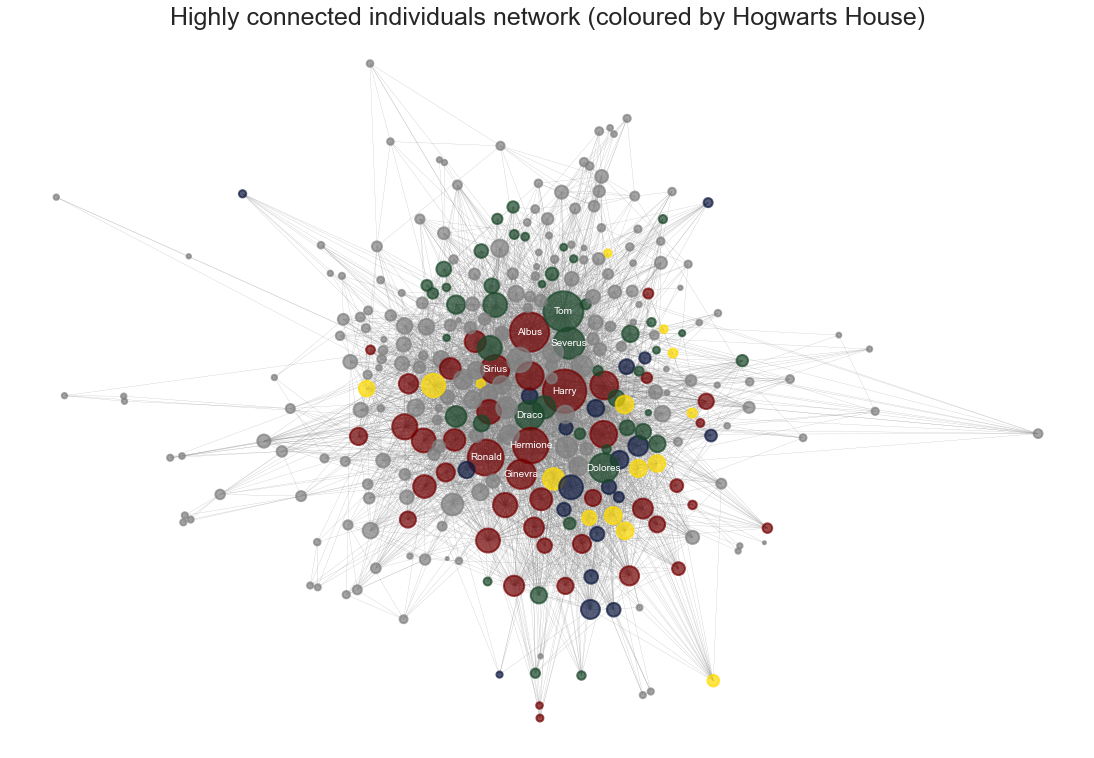

In [55]:
# And we're ready to visualise:

plt.figure(figsize=(15,10))

nx.draw(nx.to_undirected(G_high), 
        positions, 
        with_labels = False, 
        node_size = node_sizes, 
        node_color = node_colors,
        edge_color = edge_colors,
        width=0.2,
        linewidths=2,
        alpha = 0.7);

# And this time, let's put labels on the most connected nodes:
nx.draw_networkx_labels(G_high, positions, labels, font_size = 10, font_color = 'white');

plt.title("Highly connected individuals network (coloured by Hogwarts House)", fontsize=25, ha='center')
plt.show()

The figure above shows the highly connected individuals in the network. The grey nodes indicate that the character has no Hogwarts house, while the coloured nodes indicate the house colour of the character. Notice that the highly connected characters are labeled.

The colours are as follows:
* Red: Gryffindor
* Green: Slytherin
* Yellow: Huffelpuff
* Blue: Ravenclaw

There are other attributes to explore, namely _blood type_, _book number_ among others. Let's visualize these:

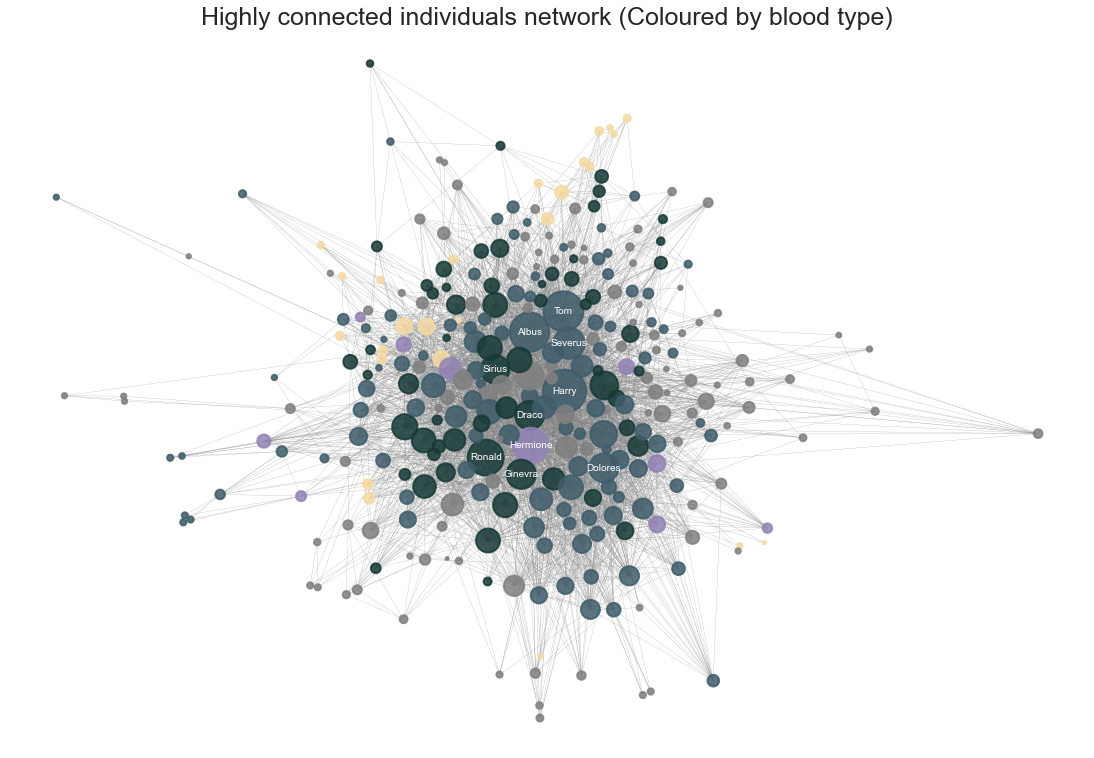

In [56]:
# Plotting by blood type

blood_colours = {
		'Pure-Blood' : '#173a37',
		'Half-Blood' : '#3f5d6b',
		'Muggle-Born' : '#9283b6',
		'Muggle' : '#f6daa4'
}

grey = '#808080'

# Assigning colours to nodes

node_colors = [blood_colours[blood] if blood in blood_colours else grey for (node, blood) in G_high.nodes.data('blood')]

# Assigning colour to edges

edge_colors = [grey for (u,v) in G_high.edges]

# And we're ready to visualise again:

plt.figure(figsize=(15,10))

nx.draw(nx.to_undirected(G_high), 
        positions, 
        with_labels = False, 
        node_size = node_sizes, 
        node_color = node_colors,
        edge_color = edge_colors,
        width=0.2,
        linewidths=2,
        alpha=0.85);

# And this time, let's put labels on the most connected nodes:
nx.draw_networkx_labels(G_high, positions, labels, font_size = 10, font_color = 'white');

plt.title("Highly connected individuals network (Coloured by blood type)", fontsize=25, ha='center')
plt.show()

The network above shows the same network as before (highly connected individuals subgraph), but now nodes are coloured by Blood type. The colours are as follows:

* Beige is Muggle 
* Purple is Muggle-born 
* Blue is Half-blood 
* Dark blue is Pure-blood.

Notice how the half-bloods tend to group together, as well as the pure-bloods. A similar pattern can also be observed with Muggles.

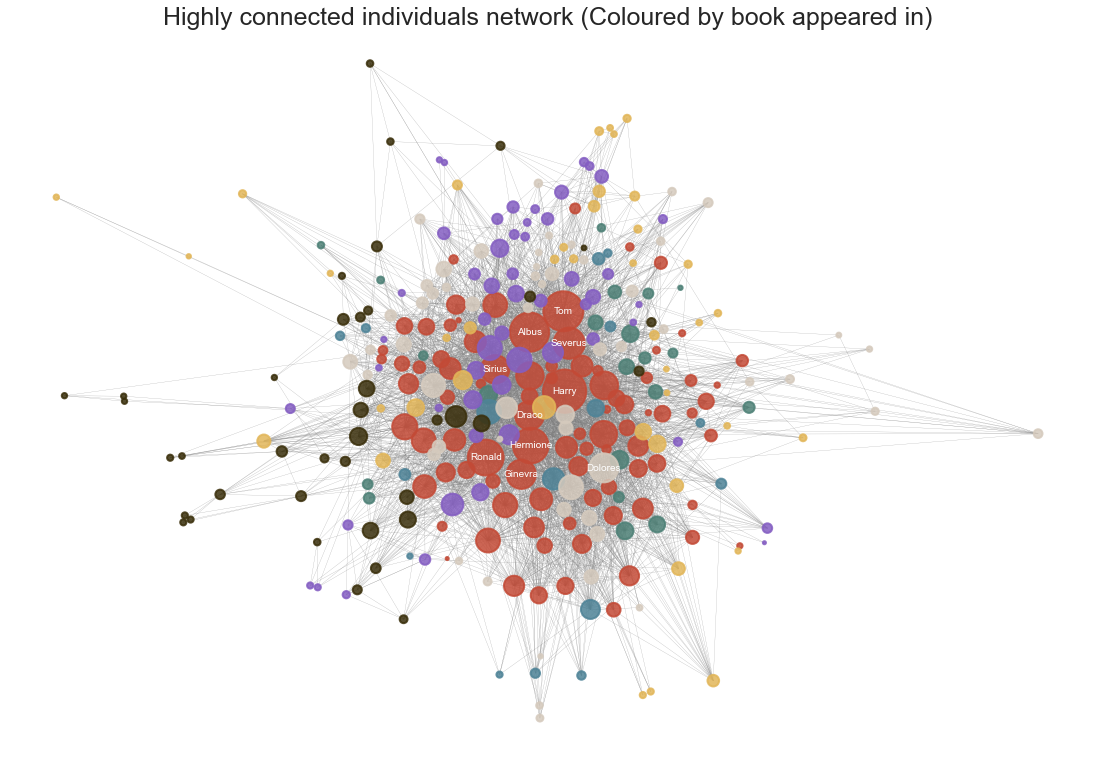

In [58]:
# Plotting by book number

book_colours = {
		1 : '#c34a36',
		2 : '#4d8076',
		3 : '#4e8397',
		4 : '#845ec2',
		5 : '#d5cabd',
		6 : '#e2b659',
		7 : '#3a2f0b'
}

grey = '#808080'

# Assigning colours to nodes

node_colors = [book_colours[book] if book in book_colours else grey for (node, book) in G_high.nodes.data('book_nr')]

# Assigning colour to edges

edge_colors = [grey for (u,v) in G_high.edges]

# And we're ready to visualise once again:

plt.figure(figsize=(15,10))

nx.draw(nx.to_undirected(G_high), 
        positions, 
        with_labels = False, 
        node_size = node_sizes, 
        node_color = node_colors,
        edge_color = edge_colors,
        width=0.2,
        linewidths=2,
        alpha=0.85);

# And this time, let's put labels on the most connected nodes:
nx.draw_networkx_labels(G_high, positions, labels, font_size = 10, font_color = 'white');

plt.title("Highly connected individuals network (Coloured by book appeared in)", fontsize=25, ha='center')
plt.show()

The network above shows the same network as before, but now nodes are coloured by Book number (the book the character first appeared in). The colours are fairly irrelevant, but notice how characters that are introduced in the same book tend to cluster together.

**Finally, let's visualise the network with only highly connected individuals with Hogwarts houses:**


In [59]:
min_connectivity = 3

nodes_with_houses = [node for node in G.nodes if G.nodes[node]['house'] != 'Unknown' and G.in_degree[node] >= min_connectivity and G.out_degree[node] >= min_connectivity]


G_houses = G.subgraph(nodes_with_houses)

print("Size of new (houses only) individuals subgraph: {}".format(len(G_houses)))

Size of new (houses only) individuals subgraph: 124


In [60]:
# Setting house colour
node_colors = [house_colors[house] if house in house_colors else grey for (node, house) in G_houses.nodes.data('house')]

# Let's find the most connected nodes again
top_nodes = dict(sorted(nx.degree_centrality(G_houses).items(), key = operator.itemgetter(1), reverse = True)[0:15])
top_nodes = list(top_nodes.keys())

# Generate the labels
labels = {}
for node in G_houses.nodes():
    if node in top_nodes:
        # Set the node name as the key and the label as its value
        labels[node] = node.split(' ')[0]
        

# Resetting sizes
node_sizes = [val*1500 for val in nx.degree_centrality(G_houses).values()] 

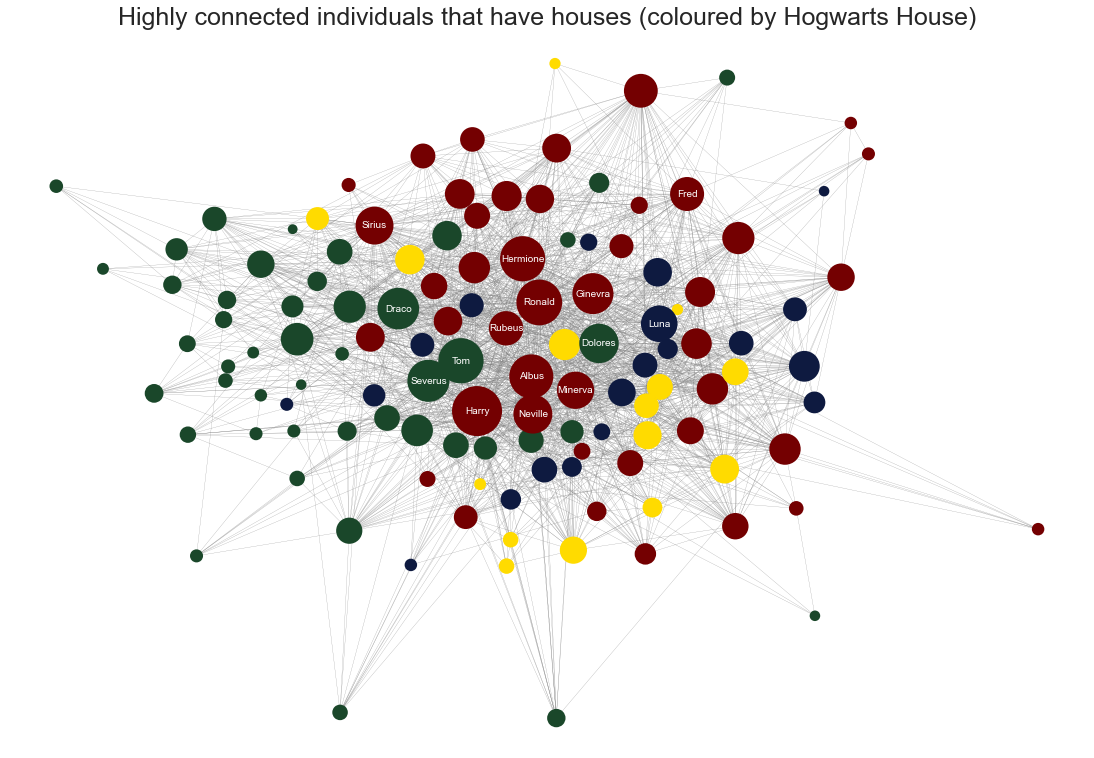

In [61]:
# positioning nodes

positions = forceatlas2.forceatlas2_networkx_layout(G_houses, 
                                                    pos=None, 
                                                    iterations=2000);

# And we're ready to visualise once again: 

plt.figure(figsize=(15,10))

nx.draw(nx.to_undirected(G_houses), 
        positions, 
        with_labels = False, 
        node_size = node_sizes, 
        node_color = node_colors,
        edge_color = edge_colors,
        width=0.2,
        linewidths=2);

# And this time, let's put labels on the most connected nodes:
nx.draw_networkx_labels(G_houses, positions, labels, font_size = 10, font_color = 'white');

plt.title("Highly connected individuals that have houses (coloured by Hogwarts House)", fontsize=25, ha='center')
plt.show()

It can be seen that the highly connected nodes with houses are actually not many compared to the whole Wiki network. Notice how the different houses tend to cluster together. This network includes most of the main characters of the Fandom universe! Notable characters are:

* Harry
* Ron
* Hermione
* Snape (Severus)
* Hagrid (Rubeus)
* ...

### 3.1.1. Outcome

The Wiki network makes sense. While not all pages in the data represented characters ('individuals'), the connections seem to make sense. Furthermore, pets, spells and other Harry Potter universe-like entities are common in the data, although thankfull it mostly consists of individuals. <b>Wizardkind</b> was the highest in-degree node, followed only by <b>Harry Potter</b> himself. This makes sense in the context of WikiPages, as connecting topics to _'Wizardkind'_ is common in the books and the films as well. Of course, Harry is the center of this universe and as such has the highest in-(and out-)degree.

Plotting such a graph is a challenge, and was solved here by imposing a minimum 'connectivity' (in-, and out-degree <= min_connectivity) to the nodes included in the visualizations. The various attributes available in the data are useful for colouring the nodes and highlighting different aspects of the network.

The degree distributions in the histogram and loglog graphs, as well as in the highlighted scatterplots, show signs of a scale-free network. Many nodes in the network are lowly connected, while others (like Harry Potter, Tom Riddle (also known as Lord Voldemort in the universe), and other popular characters) have a disproportionatly high degree. 



---

<a id='3-1-2-networkanalyses'></a>
### 3.1.2 Wiki network statistics and analyses

Here, we're interested in further analysing the degree distributions of the network, with the new subnetwork we've created containing only individuals. Furthermore, we want to analyse the different attributes in the network (node type, Hogwarts house etc.) and display their distributions.

For this, we continue to use networkX, but we also rely heavily on plotting packages, such as Matplotlib, Seaborn and PyPlot. The aim is to shed some light on what the distribution of characters is in the Harry Potter (Fandom) universe, and what attributes they share.

**Degree distribution analysis**

Let's explore the in-degree and out-degree distributions. The best way to do this is with a Histogram and a Log-log graph:

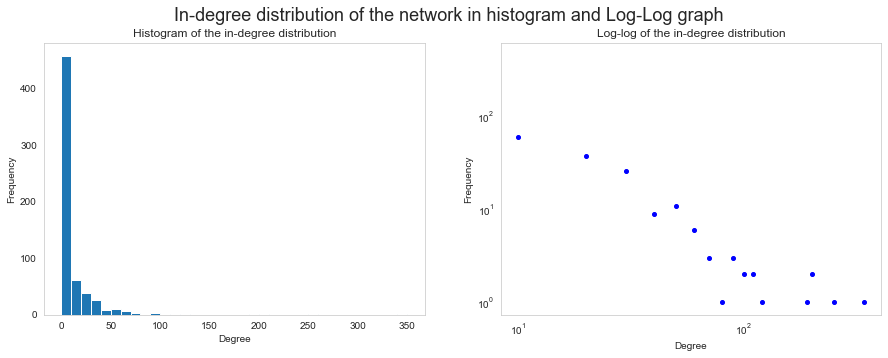

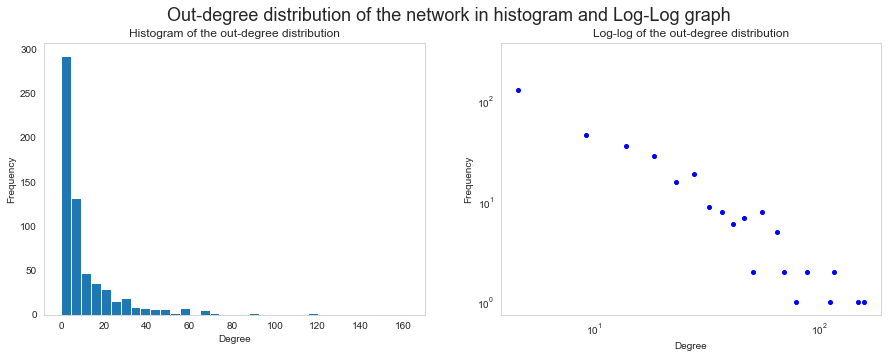

In [62]:
# Calling the predefined distribution visualisation functions

display_histogram_and_loglog_distributions(G_type=G.in_degree(), #Plotting the in-degree distribution
                                           bins=35, 
                                           print_str="in-degree", 
                                           title="In-degree distribution of the network in histogram and Log-Log graph")

display_histogram_and_loglog_distributions(G_type=G.out_degree(), # Plotting the out-degree distribution
                                           bins=35, 
                                           print_str="out-degree", 
                                           title="Out-degree distribution of the network in histogram and Log-Log graph")


The WikiPage network of individuals seems to show scale-free properties. It's very frequent to have little to no in-degrees, but the scale of in-degree distributions stretches fairly high. The out-degree distributions are more evenly distributed, with a few extremes as well. Notice that the in-degree scale streches more than double the length of the out-degree scale!

Now let's explore these distributions in scatter plots:

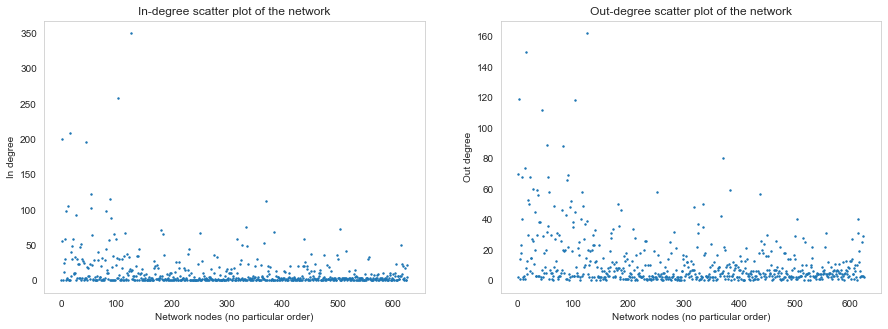

In [63]:
# Exploring the degree distributions through scatterplots

axs = make_scatter_plots(G)
plt.show()

It can clearly be seen from the figures above that the in-degree distribution tends to hover more around the bottom than in the out-degree distribution. That is, it is denser towards 0. Furthermore it looks like the out-degrees reach the same heights as the in-degrees, but that is because the scales are not equalized, let's account for this:

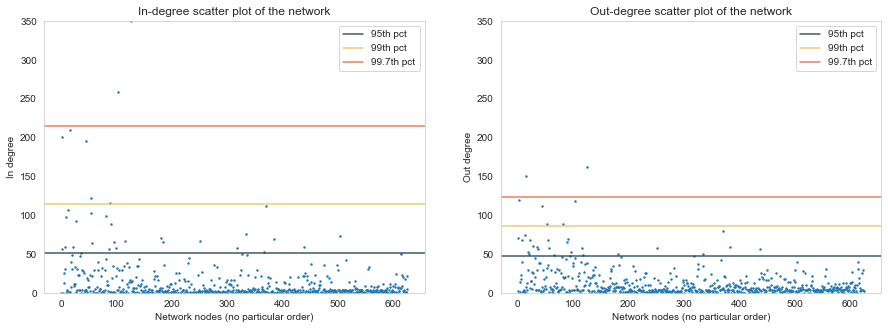

In [64]:
# Finding high percentiles in the degree distributions

axs = make_scatter_plots(G, 
                         with_percentiles = True, 
                         equalize_y_axis = True)

plt.show()

The figure above shows the in-, and out-degree distributions of the individuals network, with the scales equalized and high percentiles added. It's clear that as we have noted before, the in-degrees stretch higher than the out-degrees. Notice how the high percentile (99.7th) is much higher on the left graph.

Finally, let's explore which nodes are the highly connected ones in terms of in-, and out-degrees, in this new individual network:

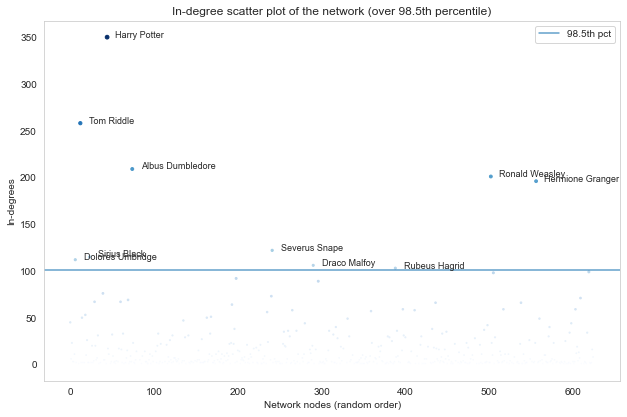

In [79]:
# Investigation of highest in-degree nodes: 

nodes = [node for node in G.nodes] # for this we need all nodes in network
node_indices = [i for i in range(len(G.nodes))] # indices

random.shuffle(nodes) # randomising the list for ordering (with same seed)

in_degrees = [G.in_degree(node) for node in nodes] # All in-degree values
out_degrees = [G.out_degree(node) for node in nodes] # All out-degree values

plot_scatter_with_labels_over_percentile(in_degrees, 
                                         "In-degrees", # Axis string
                                         "In-degree scatter plot of the network (over 98.5th percentile)", # Plot title 
                                         98.5 # percentile
                                        )

plt.show()

The figure above shows the high percentiles of in-degree distribution. All these characters are very well known and as such this should come as no surprise. Note that Tom Riddle here is also known as Lord Voldemort in the universe.

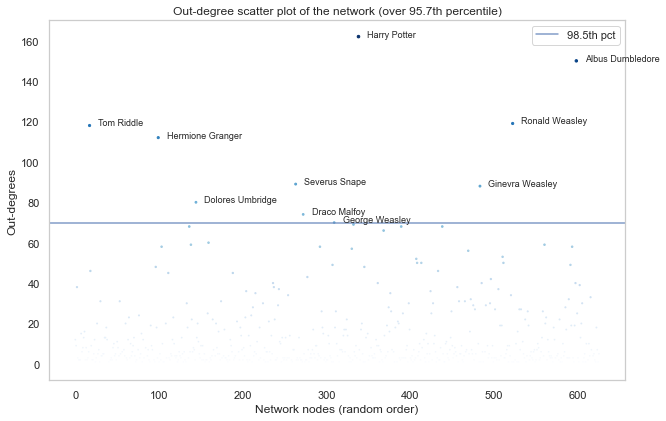

In [89]:
# Investigation of highest out-degree nodes:

plot_scatter_with_labels_over_percentile(out_degrees, 
                                         "Out-degrees", # Axis string
                                         "Out-degree scatter plot of the network (over 95.7th percentile)", # Plot title 
                                         98.5 # percentile
                                        )

As makes sense from a WikiPage network, the high-percentile out-degree nodes are very similar to the in-degree nodes. This means that these nodes had the most amount of links to other nodes in the network. 

This indicates that even though the network has hubs on the in-degree spectrum, those same nodes have the most out-degrees too (albeit far lower)! This could mean that these high-degree WikiPages have an unfair advantage of being disproportionally updated - the pages themselves grow larger (because they're already large), and are referenced from other pages (because they're so large, and hence important).

**Other analyses - Attribute statistics**

Let's explore what the frequencies of different attributes are in the network:

**Book number first appeared in:**

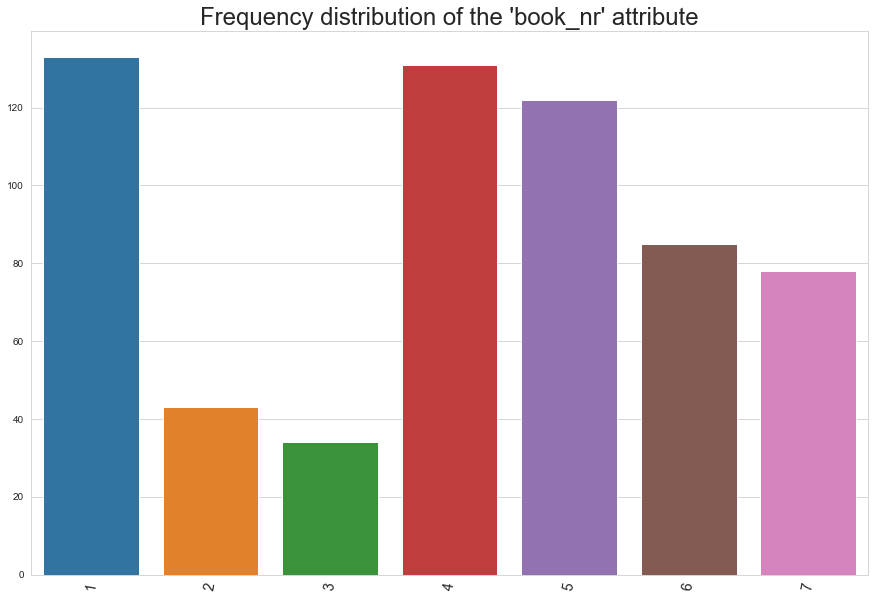

In [80]:
def plot_attribute(attribute, entity_types = False, comparing = False, disgarding_unknowns = False):
    # Setting style
    sns.set_style("whitegrid")

    # Getting the types of WikiPages in the network
    if not entity_types:
        entity_types = [book for (node, book) in G.nodes.data(attribute)]

    # Sorting the values by frequency
    types = {key: value for key, value in sorted(collections.Counter(entity_types).items(), 
                                                 key=lambda item: item[1], reverse=True)}

    # Preparing figure
    if not comparing:
        plt.figure(figsize=(15,10))
    else:
        plt.figure(figsize=(7,5))

    # Plotting Wiki types
    fig = sns.barplot(
        x = list(types.keys()),
        y = list(types.values())
    )

    plt.xticks(rotation=80, size=14)
    if disgarding_unknowns:
        plt.title("Frequency distribution of the '{}' attribute (disgarding unknown nodes)".format(attribute), 
                  fontdict = {'fontsize' : 24})
    else:
        if comparing:
            plt.title("Comparison between nodes that have known attribute '{}' vs those that do not".format(attribute), 
                  fontdict = {'fontsize' : 14})

        else:
            plt.title("Frequency distribution of the '{}' attribute".format(attribute), 
                  fontdict = {'fontsize' : 24})

    plt.show()

plot_attribute("book_nr")

The figure above represents the distribution of which book the Wikipages were corresponding to. Perhaps unsurprisingly, book 1 has the highest number of first appearances, but book 4 and 5 seem to shake things up considerably in the Harry Potter universe. Noticably low is book 3 (Prisoner of Azkaban) with less than 50 characters.

**Character gender:**

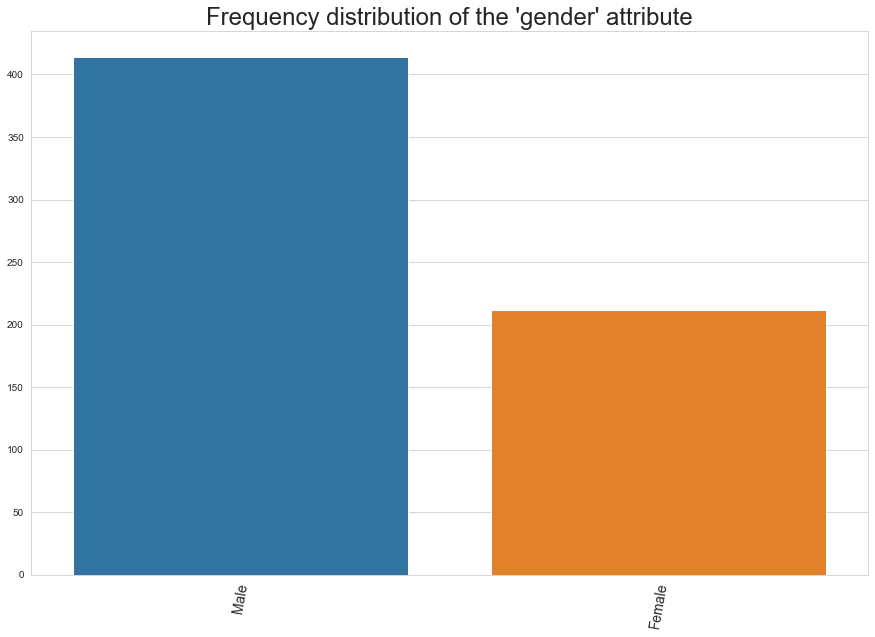

In [81]:
plot_attribute("gender")

The figure above shows the distribution of the two main genders (Male and Female) in the Individual network. Note that the amount of males is almost double that of the amount of females. This distribution is sadly unsurprising when it comes to popular culture and fiction, but perhaps a little bit surprising given that the author of the stories is female. 

**Character hair:**

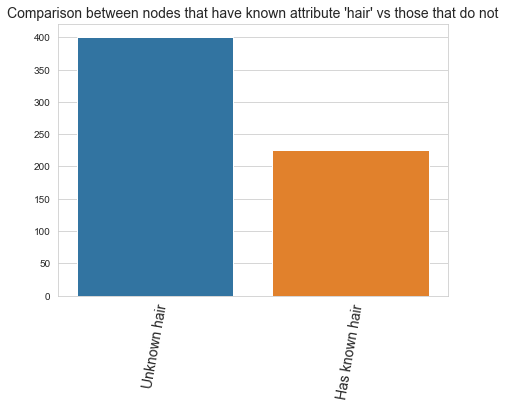

In [82]:
nodes_with_hair = ["Has known hair" if hair != "Unknown" else "Unknown hair" for (node, hair) in G.nodes.data('hair')]
plot_attribute("hair", nodes_with_hair, comparing=True)

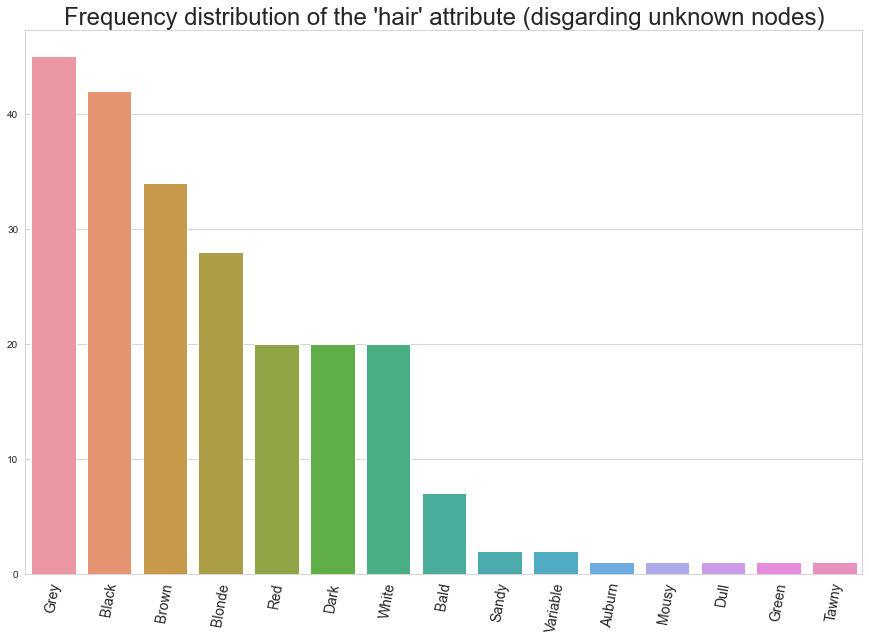

In [83]:
# Finding the hair values from the nodes
nodes_hair = [hair for (node, hair) in G.nodes.data('hair')]

nodes_hair_no_unknowns = [hair for hair in nodes_hair if hair != "Unknown"]

plot_attribute("hair", nodes_hair_no_unknowns, disgarding_unknowns=True)

The figure above shows the distribution of hair colour (or other description of hair) for those that are known in the network. In the wizarding world, it might not be too surprising that grey hair is the most common. Indeed, the Dumbledore look seems to be forever in fashion in the universe, and some great wizards live up to hundreds of years old.

**Character eyes:**

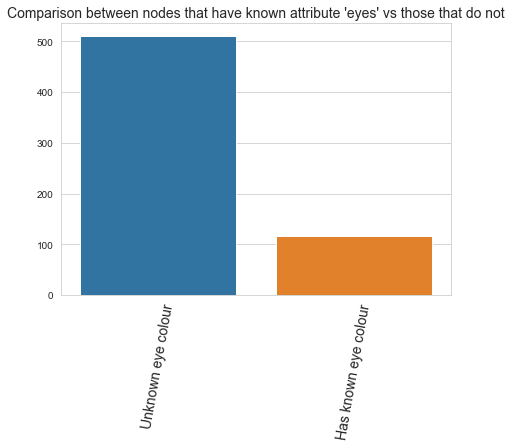

In [84]:
nodes_with_eyes = ["Has known eye colour" if eyes != "Unknown" else "Unknown eye colour" for (node, eyes) in G.nodes.data('eyes')]
plot_attribute("eyes", nodes_with_eyes, comparing=True)

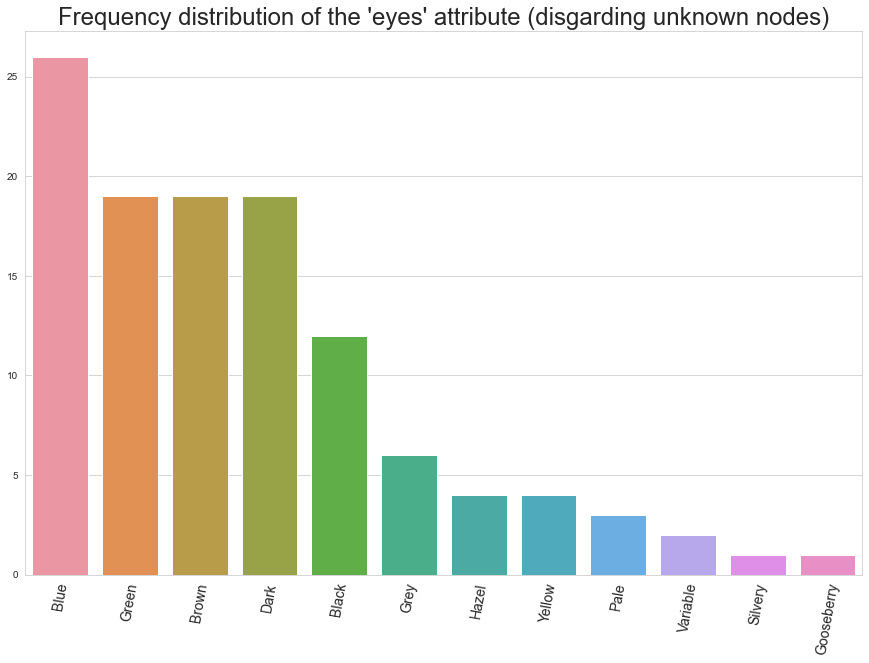

In [85]:
# Finding the hair values from the nodes
nodes_eyes = [eyes for (node, eyes) in G.nodes.data('eyes')]

nodes_eyes_no_unknowns = [eyes for eyes in nodes_eyes if eyes != "Unknown"]

plot_attribute("eyes", nodes_eyes_no_unknowns, disgarding_unknowns=True)

The figure above shows the distribution of the known eye colours in the network. Blue eyes are the most common, perhaps unsurprisingly, with Green, Brown and Dark all being equal for second. 'Dark' and 'Black' are perhaps the most striking results, indicating perhaps villanous features. 

**Character species:**

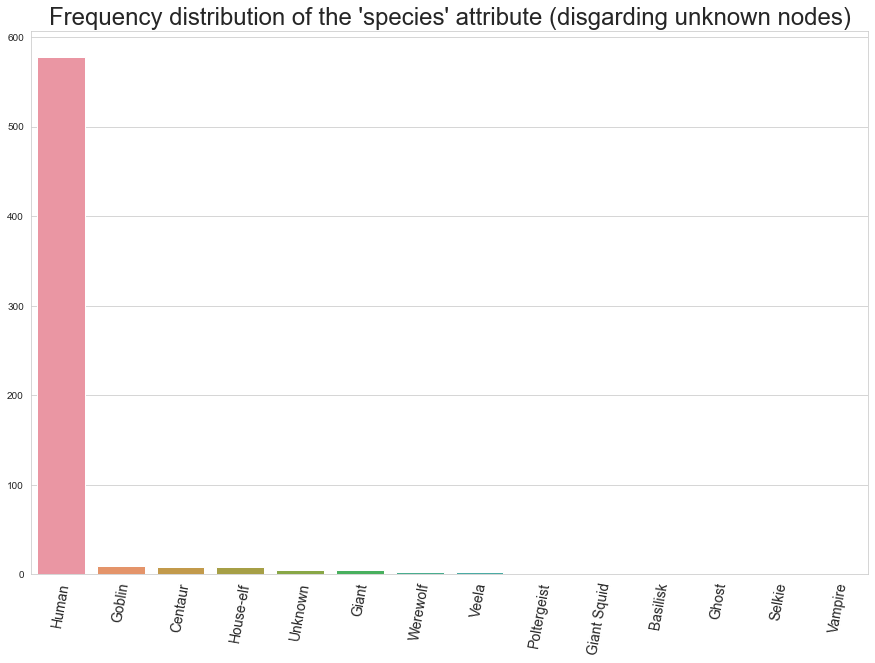

In [86]:
# Species

plot_attribute("species", disgarding_unknowns=True)

The figure above shows the distribution of the different species in the universe. Unsurprisingly, Human is by far the most common. Goblins, house-elfs and centaurs are all part of the Harry Potter storyline, as well as Ghosts. 

**Character nationality:**

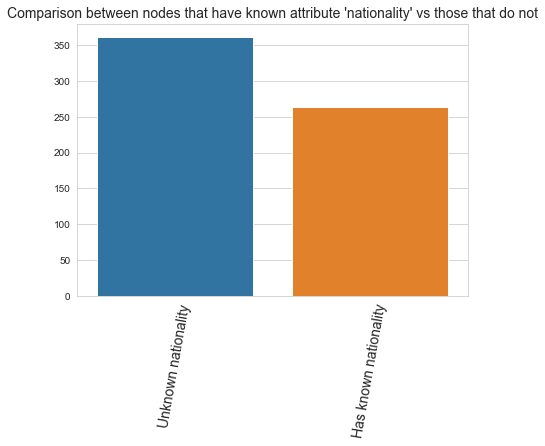

In [87]:
# Nationality

nodes_with_nationality = ["Has known nationality" if nation != "Unknown" else "Unknown nationality" for (node, nation) in G.nodes.data('nationality')]
plot_attribute("nationality", nodes_with_nationality, comparing=True)

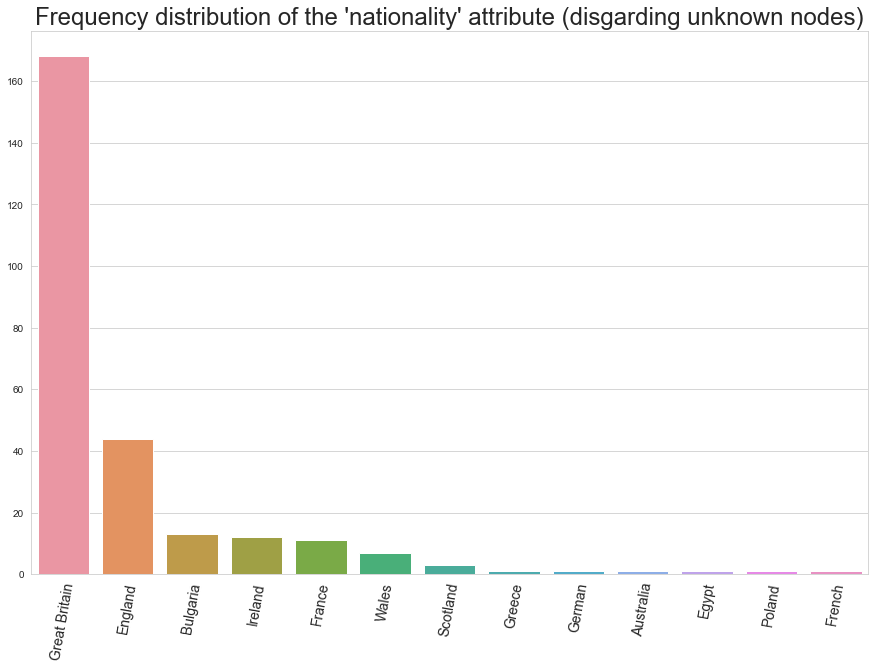

In [88]:
nodes_nations = [nation for (node, nation) in G.nodes.data('nationality')]

nodes_nations_no_unknowns = [nation for nation in nodes_nations if nation != "Unknown"]

plot_attribute("nationality", nodes_nations_no_unknowns, disgarding_unknowns=True)

The figure above shows the distribution of nationalities in the universe. These results are not surprising, as the books (and films) featured a very British narrative. It was decided to leave "England", "Wales" and "Scotland" out of "Great Britain", though they are of course technically the same region. 

Bulgaria is the most common after the British Isles, with France coming third.

Now that we've looked at some of the descriptive attributes of the dataset, we are taking a special look at the remaining two: <b>Hogwarts house</b> and <b>Blood type</b>. We're hypothesizing that we'll see some relationship between the two later on.

**Hogwarts house:**

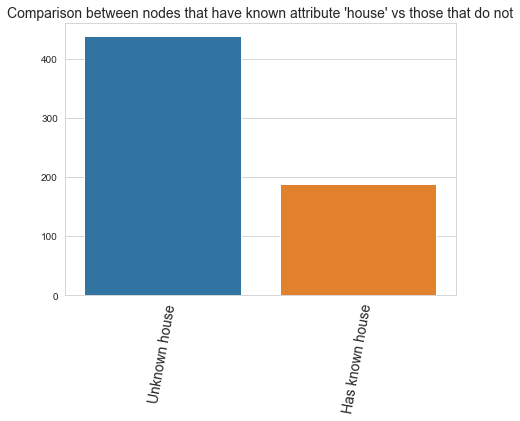

In [89]:
node_houses = ["Has known house" if house != "Unknown" else "Unknown house" for (node, house) in G.nodes.data('house')]
plot_attribute("house", node_houses, comparing=True)

The figure above shows the proportion of nodes with a known Hogwarts house versus the nodes without a known house. Unfortunately, the unknown house nodes are more than double the amount of the known house nodes. 

In the later plots, however, we will only work with the nodes that have a known house, and disregard the others.

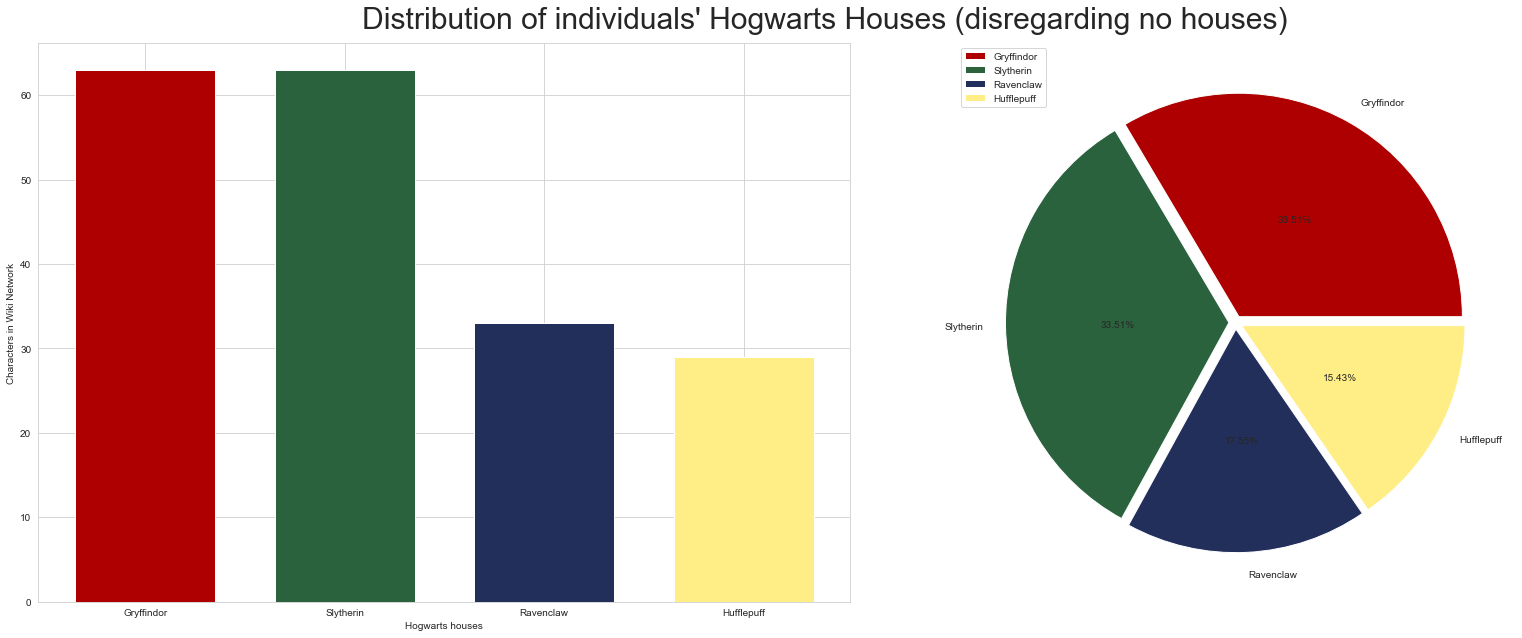

In [90]:
# Setting style
sns.set_style("whitegrid")


# Getting the houses of the individuals in the network
node_houses = [house for (node, house) in G.nodes.data('house')]
node_houses = [house for house in node_houses if house != "Unknown"]


# Sorting the values by frequency
types = {key: value for key, value in sorted(collections.Counter(node_houses).items(), 
                                             key=lambda item: item[1], reverse=True)}

houses = list(types.keys())
frequencies = list(types.values())

color_set = ('#AE0001', '#2A623D', '#222F5B', '#FFED86')

labels = houses

fig, axs = plt.subplots(1, 2, figsize=(23, 9))

axs[0].bar(houses, frequencies, color=color_set, width=0.7)
axs[0].set_xlabel("Hogwarts houses")
axs[0].set_ylabel("Characters in Wiki Network")
#axs[0].set_title("Barplot of character's frequency in Hogwarts houses", fontdict = {'fontsize' : 20})

test = {
    "Hello": 55,
    "World": 25
}

# Visualising pie plot
axs[1].pie(x=frequencies, autopct="%.2f%%", explode=[0.03]*4, labels=labels, colors = color_set,  pctdistance=0.5)
#axs[1].set_title("of character's frequency in Hogwarts houses", fontdict = {'fontsize' : 20})
axs[1].legend(loc='upper left')
plt.suptitle("Distribution of individuals' Hogwarts Houses (disregarding no houses)", size=30)
fig.tight_layout()


The figure above shows the distributions of Hogwarts houses of the nodes with a known Hogwarts house. The barchart on the left shows the same information as the pieplot on the right.

Perhaps unsurprisingly, Gryffindor and Slytherin are neck and neck with the highest frequencies, with 33% each. Ravenclaw comes third with 17.5% and Hufflepuff sits at the bottom with 15.4%. 

This makes sense, as most of the main characters are in Gryffindor and Slytherin, and indeed a large theme of the book is the paralellism between the two houses. This means that many characters (including Harry) are narrowly chosen to one of the houses over the other, based on some character attributes. 

**Blood types**

_Now let's explore what the distribution of blood types is in the Universe:_

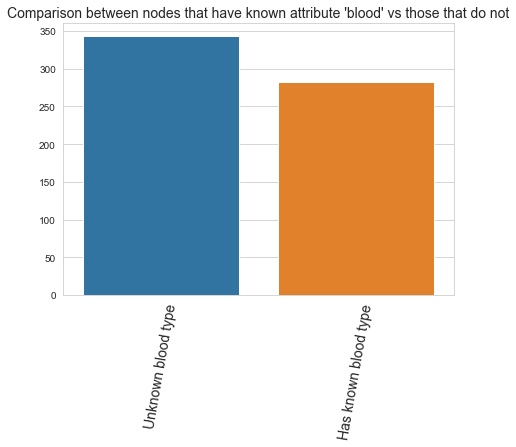

In [91]:
node_blood = ["Has known blood type" if blood != "Unknown" else "Unknown blood type" for (node, blood) in G.nodes.data('blood')]
plot_attribute("blood", node_blood, comparing=True)

Unfortunately, it seems like there's a lot of missing data on blood types again. But we have almost 300 individuals with a noted blood type (or several, but that has been cleaned). Let's see the distribution:

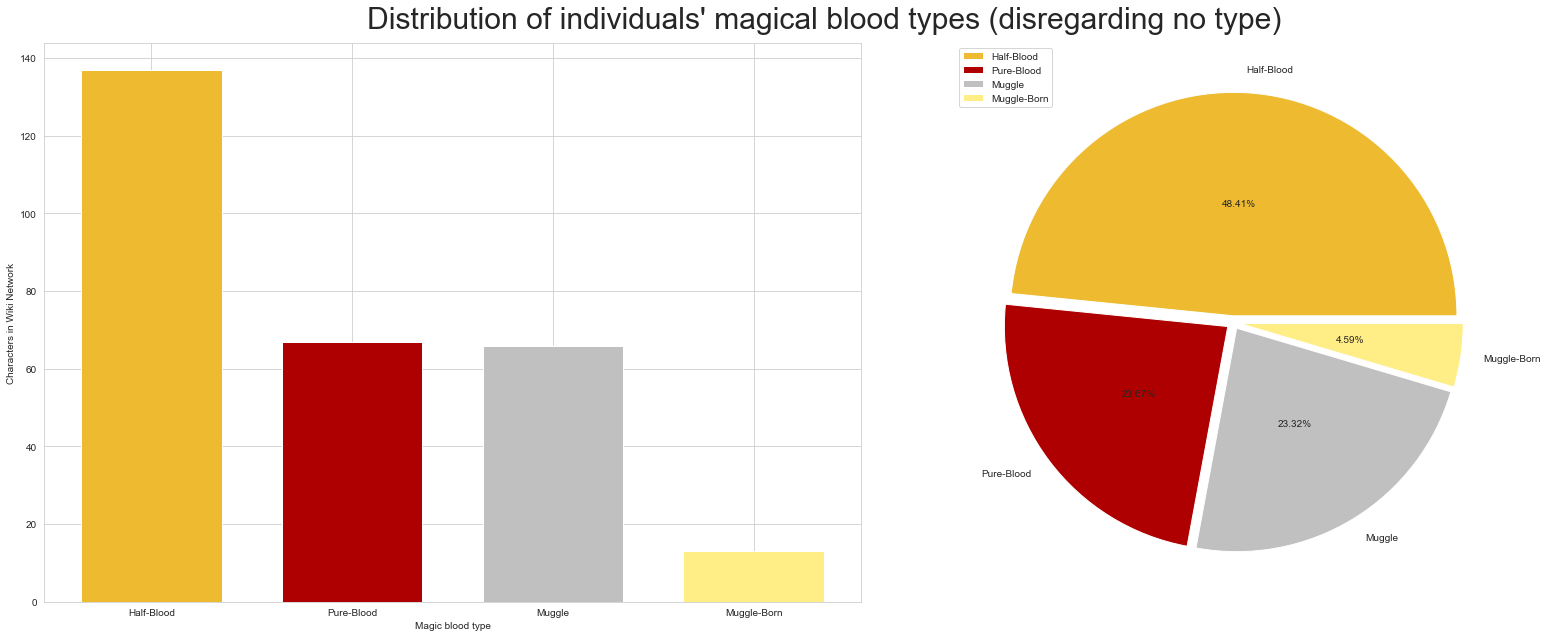

In [92]:
# Setting style
sns.set_style("whitegrid")

blood_types = ["Has blood type" if blood_type != "Unknown" else "Unknown blood type" for (node, blood_type) in G.nodes.data('blood')]

# Getting the blood types of the individuals in the network
node_blood_types = [blood_type for (node, blood_type) in G.nodes.data('blood')]
node_blood_types = [blood_type for blood_type in node_blood_types if blood_type != "Unknown"]

# Sorting the values by frequency
types = {key: value for key, value in sorted(collections.Counter(node_blood_types).items(), 
                                             key=lambda item: item[1], reverse=True)}
blood_types = list(types.keys())
frequencies = list(types.values())

color_set = ('#EEBA30', '#AE0001', '#C0C0C0', '#FFED86')

labels = blood_types

fig, axs = plt.subplots(1, 2, figsize=(23, 9))

axs[0].bar(blood_types, frequencies, color=color_set, width=0.7)
axs[0].set_xlabel("Magic blood type")
axs[0].set_ylabel("Characters in Wiki Network")
#axs[0].set_title("Barplot of character's frequency in Hogwarts houses", fontdict = {'fontsize' : 20})

# Visualising pie plot
axs[1].pie(x=frequencies, autopct="%.2f%%", explode=[0.03]*4, labels=labels, colors = color_set,  pctdistance=0.5)
#axs[1].set_title("of character's frequency in Hogwarts houses", fontdict = {'fontsize' : 20})
axs[1].legend(loc='upper left')
plt.suptitle("Distribution of individuals' magical blood types (disregarding no type)", size=30)
fig.tight_layout()


The Harry Potter universe seems to be mostly populated by half-blood witches and wizards. Pure-bloods and Muggles are also common, with muggle-born witches and wizards being least common.

Being Muggle-Born is quite rare, as both parents of a witch or wizard have to be muggles, which is obviously not a likely occurrence. 

Half-bloods are more common than expected, but this still makes sense as this column could include those that have somewhat diluted blood in their family tree. Pure-blood families are indeed very proud, and it was the opinion of some of them that witches and wizards should not mix with muggles. The founder of the Slytherin house shared that sentiment, and wanted to forbid the teaching of half-bloods and muggles in the Hogwarts school. So much so, that he sealed the Chamber of Secrets and left in it a terrible monster, waiting to one day purge the school of those who are not pureblood. This is why we anticipate that Slytherin will have a disproportionate number of pure-bloods, as a trace of this characteristic of the house. 


To explore this, let's look at <b>Blood types</b> by <b>houses</b> and confirm whether our hypothesis that a relationship exists between the two is true. In addition to the previously stated hypothesis, it is expected that Slytherin also has disproportionately few <b>muggle-born</b> members.

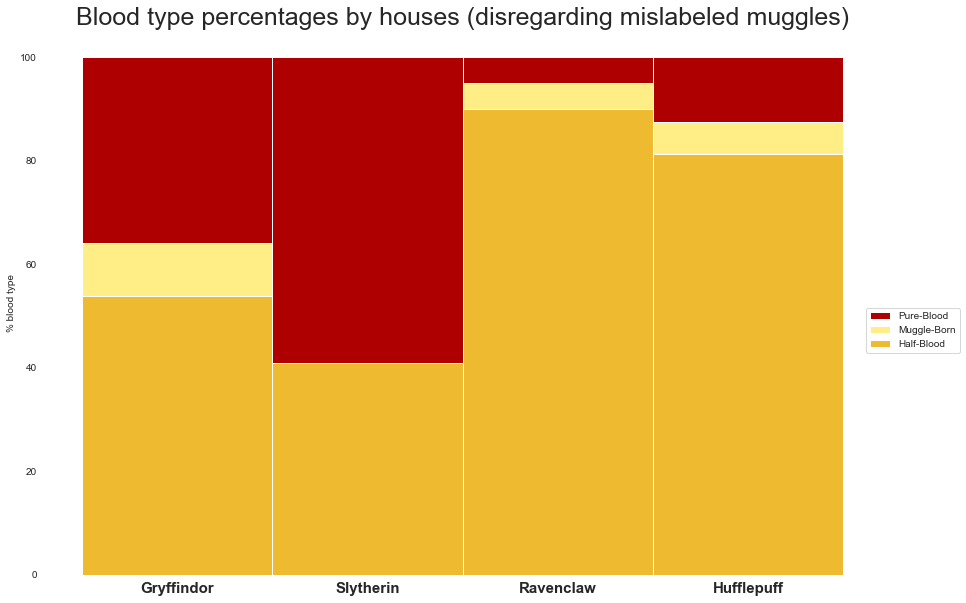

In [93]:
sns.set_style("whitegrid", {'axes.grid' : False})

# Fetching nodes that have a valid blood type
blood_type_nodes = [node if blood_type != "Unknown" else None for (node, blood_type) in G.nodes.data('blood')]

# Fetching nodes that have a valid house
house_nodes = [node if house != None else None for (node, house) in G.nodes.data('house')]

# Intersecting the two
blood_types_and_houses =  list(set(blood_type_nodes) & set(house_nodes))

# Declaring a dict to store the data
houses_by_blood_type = {
    "Pure-Blood": [0, 0, 0, 0],
    "Muggle": [0, 0, 0, 0],
    "Muggle-Born": [0, 0, 0, 0],
    "Half-Blood": [0, 0, 0, 0]
}

for i in range(len(houses)):
    curr_house = houses[i]
    for node in blood_types_and_houses: # looping through the nodes we know both have a house and blood type
        if node: # bug fix
            nd = G.nodes[node]
            if (nd['house']  == curr_house):
                blood_type = nd['blood']
                houses_by_blood_type[blood_type][i] += 1 # Setting blood type's house index to +1
                
plt.figure(figsize=(15,10))

# Defining same colour set as before for blood types
color_set = ('#AE0001', '#C0C0C0', '#FFED86', '#EEBA30')

# Setting the positions for the bars
x_positions = list(range(len(houses_by_blood_type)))

houses_by_blood_type['Muggle'] = [0, 0, 0, 0] # We don't want muggles, as they're mislabeled

# Getting the values for the houses for each blood type
pure_bloods = np.array(houses_by_blood_type['Pure-Blood'])
muggles = np.array(houses_by_blood_type['Muggle'])
muggle_born = np.array(houses_by_blood_type['Muggle-Born'])
half_bloods = np.array(houses_by_blood_type['Half-Blood'])

# Adding the arrays up to get the total amount of individuals by house
tot_individuals = pure_bloods + muggles + muggle_born + half_bloods

# Getting the percentages
pure_bloods = pure_bloods / tot_individuals * 100
muggles = muggles / tot_individuals * 100
muggle_born = muggle_born / tot_individuals * 100
half_bloods = half_bloods / tot_individuals * 100

# Plotting the actual bars
ax0 = plt.bar(x_positions, pure_bloods, bottom = muggles + muggle_born + half_bloods, edgecolor="White", width=1, label='Pure-Blood', color = color_set[0])
ax1 = plt.bar(x_positions, muggles, bottom = muggle_born + half_bloods, edgecolor="White", width=1, color = color_set[1])
ax2 = plt.bar(x_positions, muggle_born, bottom = half_bloods, edgecolor="White", width=1, label='Muggle-Born', color = color_set[2])
ax3 = plt.bar(x_positions, half_bloods, edgecolor="White", width=1, label='Half-Blood', color = color_set[3])

# Setting plot details
plt.xticks(x_positions, houses, fontweight='bold', size = 15)
#plt.xlabel("Hogwarts house")
plt.ylabel("% blood type")
ax = plt.gca()
plt.legend(bbox_to_anchor=(1.1, 0.5))
#plt.legend()
plt.title("Blood type percentages by houses (disregarding mislabeled muggles)", size = 25)
sns.despine(bottom = True, left = True)

plt.show()

The figure above shows the percentages of the different blood types between the different Hogwarts houses (disregarding a few mislabeled Muggles). Our hypothesis would seem to be true, with Slytherin having over half pure-bloods. Gryffindor also has a sizeable amount, with Ravenclaw and Hufflepuff having very few. 

Furthermore, all the houses except Slytherin have at least some muggle-born individuals. This confirms our second hypothesis that Slytherin would not be a likely home to muggle-born students.

However, it is worth noting here that the few muggles that were mislabeled were part of Slytherin, but were removed as that's a clear mislabel.

### 3.1.2. Outcome

The network of individuals retains much of the degree distribution property of the whole network. This was displayed early on in this chapter, as indications show a scale-free trend. However, the highest in-degree nodes and the highest out-degree node correspond a lot, meaning that these highly connected nodes are connected both ways. As mentioned before, this could give rise to a bias in the Wiki network, where a few supernodes continue to grow as contributors write on the Fandom page.

The distribution of attributes in the network were not all too surprising, with the typical member of the network being a male, blue-eyed, grey-haired member of Gryffindor or Slytherin. Unsurprisingly, by far most of the characters were human, and most of them were from Britain. Half-bloods are very common, with Muggle-born being the least common. A very notable result was found that Slytherin houses the most Pure-bloods proportionally, and no Muggle-born witches or wizards. This is not true of the other houses, with Ravenclaw and Hufflepuff having very few non-mixed individuals

<a id='3-1-3-networkcommunitydetection'></a>
### 3.1.3 Wiki network community detection

This analysis aims to discover communities within the Wiki network. This means that we hope to find patterns within the edge distributions and adjacency matrix, revealing a specific subsection of the network that tends to point within itself. This is a challenge given the nature of the network, as we've seen, it has some highly connected nodes both on the in-degree and the out-degree spectum.


The [Infomap](https://pypi.org/project/infomap/) was tested extensively, but yielded poor results. More specifically, a single supercommunity was formed with dozens of small communities around it (a foreshadowing of this analysis in general). The communities made sense, such as the Longbottom family or some similar small subcommunity, but we desired a more concrete split on the network, with more than one big part. As such, we tested the [Lovain method](https://pypi.org/project/python-louvain/), on the recommendation of the course responsibles. The algorithm was introduced in [2008](https://arxiv.org/pdf/0803.0476.pdf), and in essence it works by unfolding the network feeding previously found partitions in each pass. The proposed strength of the algorithm is well optimized modularity and computational time. It was readily accessible to us as a Python package. 

Furthermore, to analyze both the uniqueness of the communities discovered and also their sentimental value in a later analysis, a TF-IDF (Term frequency - Inverse document frequency) computation was performed. This was done as in a previous assignment, analysing a similar Wiki network. The term frequencies of communities (adjusted for document length to avoid bias) was multiplied for the inverse document frequency to obtain the scores. The inverse document frequency was obtained by using the inverse document frequency smooth formula. In addition to this, 'noisy' or non-descriptive words were manually picked out. For this part, the preprocessing has already been done. The text is stored in the network as a lemmatized, tokenized string of non-stopwords. 

This allows for the creation of [WordClouds](https://pypi.org/project/wordcloud/). The idea is that words that are particularly descriptive of certain communities are displayed in a cloud-like figure, generated by the Python package. 

For this part we're going to work only with the Giant Connected Component, and we have to make the network undirected:

In [127]:
# Extracting the GCC
G_GCC = G.subgraph(max(nx.weakly_connected_components(G), key=len))

# And making it undirected
G_GCC = nx.to_undirected(G_GCC)

print("Original individual network had {} nodes".format(len(G)))
print("Giant connected component of individual network has {} nodes".format(len(G_GCC)))

Original individual network had 626 nodes
Giant connected component of individual network has 587 nodes


In [135]:
# Let's employ the Lovain algorithm on the network:

# Added 'house' as extra weight through much trial-and-error
partition = community.best_partition(G_GCC, weight='house') 

In [177]:
# Create a dictionary of node name and community number
communities = {}
for node in G_GCC.nodes:
    communities[node] = partition[node]
        
# Get all the community values in a single variable for counting
lovain_communities = communities.values()  

# Count and sort the communities
communities_counter = Counter(lovain_communities).most_common(max(lovain_communities))

# Add the community numbers to an attribute within the graph
nx.set_node_attributes(G_GCC, communities, "community")

Let's see how the algorithm split the individuals:

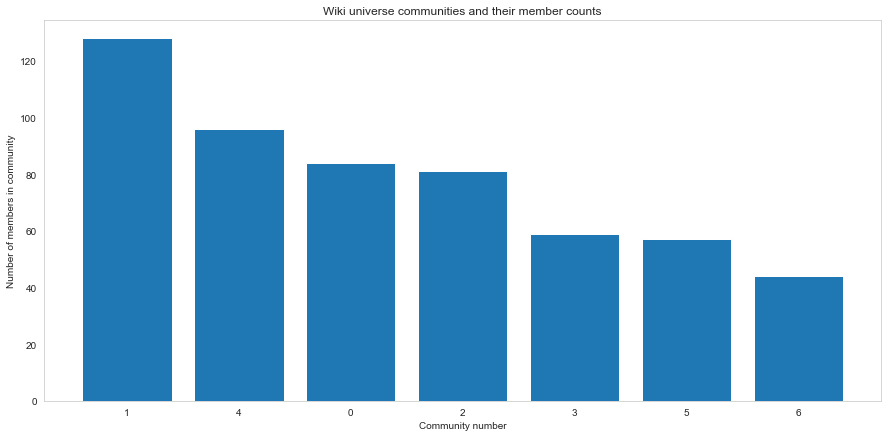

In [178]:
# Lets plot the communities and see how many are in each one
plt.figure(figsize = (15,7))

labels, values = zip(*communities_counter)
indexes = np.arange(len(labels))

plt.bar(indexes, values)
plt.xticks(indexes, labels)
plt.xlabel('Community number')
plt.ylabel('Number of members in community')
plt.title('Wiki universe communities and their member counts')
plt.show()

The figure above shows the split of the network in to communities. As can be seen, community 1 has more than 120 nodes, and there are 7 communities in total.

In [179]:
# Generate the numbers of the top 10 (if that many) communities 
top_10_communities = [el[0] for el in Counter(lovain_communities).most_common(10)]

# Let's find out the 'biggest' nodes
nodes = dict(sorted(nx.degree_centrality(G_GCC).items(), key = itemgetter(1), reverse = True)[0:10])
top_nodes = list(nodes.keys())

communities_to_nodes = {}

for node in partition:
    # creating keys for the node
    if not communities_to_nodes.get(partition[node]):
        communities_to_nodes[partition[node]] = []
    communities_to_nodes[partition[node]].append(node)

    
for community in communities_to_nodes.keys():
    curr_comm = communities_to_nodes[community]
    curr_com_with_degrees = []
    for member in curr_comm:
        curr_com_with_degrees.append([member, G_GCC.degree(member)])
    top_members = sorted(curr_com_with_degrees, key=lambda x: x[1], reverse=True)[:10]
    top_members_pd = pd.DataFrame(top_members) 

**Let's generate word clouds and see if they're descriptive of the communities:**

In [180]:
cleaned_pages = {}
# All the pages were later decided to be cleaned beforehand, but the naming remains

# Function that returns the frequency distribution of words for each community
def tf_community(community_number):
    # Extract all the members of the community
    members = [node for (node, data) in G_GCC.nodes(data=True) if data.get("community") == community_number]

    # Generate the words lists for the community
    community_words = []
    
    for member in members:
        wiki_words = G.nodes[member]['wiki_text']
        wiki_words = wiki_words.split() # Still need to split the words
        community_words.extend(wiki_words)  # Add to wordlist
        cleaned_pages[member] = wiki_words
    
    # Now we have a list of the words used in the community and create the freq dist for it
    fdist_community = nltk.FreqDist(community_words)

    # Now we normalize the raw counts by the word of the document
    for word in fdist_community:
        fdist_community[word] /= float(len(community_words))
    
    return fdist_community

In [181]:
# Collect the top communities into a dictionary
tf = {}
for community_number in top_10_communities:
    tf['community_%s' % community_number] = tf_community(community_number)
    
for community in tf:
    print(community, tf[community].most_common(3))

community_1 [('harry', 0.019695435604422443), ('potter', 0.013238833232422422), ('hogwarts', 0.011636130515968516)]
community_4 [('harry', 0.017017981729969274), ('potter', 0.011746196489320517), ('death', 0.00931623297995898)]
community_0 [('harry', 0.037891222701349286), ('potter', 0.017039922103213243), ('james', 0.006676867436361107)]
community_2 [('harry', 0.02144352252021624), ('hermione', 0.01901907931392775), ('ron', 0.016971102444019455)]
community_3 [('dumbledore', 0.02226680606968267), ('grindelwald', 0.011514877504309249), ('harry', 0.010864958037808358)]
community_5 [('weasley', 0.017530936947554508), ('harry', 0.016205067766647024), ('potter', 0.012227460223924572)]
community_6 [('voldemort', 0.01927430308518207), ('riddle', 0.015458249789793675), ('harry', 0.011405040639889615)]
community_7 [('slughorn', 0.01580672446606048), ('ministry', 0.011894692323958553), ('harry', 0.011524635229435398)]


In [209]:
# Create a copy where we will overwrite the values to include the tf idf
tf_idf = copy.deepcopy(tf)

# for each word in each community - count in how many lists it appears
for community in tf: # For each community
    for word in tf[community]: # for each word in the community

        doc_count = 0 # reset doc count
        
        for inner_community in tf: # For all communitites (again)
            if word in tf[inner_community].keys(): # if the word is a key in the inner community
                doc_count = doc_count + 1 # increase the doc count          
      

        tf_idf[community][word] = tf[community][word] * (math.log(8 / (doc_count+1))+1) # tf * Inverse document frequency
        
# Collect the word cloud objects into a dictionary
wordclouds = {}

# For the wordcloud we want to create our own list of stopwords that even after the TF-IDF occur prominently in
# each community but don't add a lot of information about the community
manual_stopwords = set(["harry", "potter", "category", "file", "also", "http"]) # Skip a few very common words and wikiwords

for idx, community_number in enumerate(top_10_communities):
    
    dictionary = tf_idf['community_%s' % community_number]
    filtered_dict = {key: value for (key, value) in dictionary.items() if key not in manual_stopwords}
    
    wordclouds[community_number] = WordCloud(collocations=False, 
                                             background_color='White', 
                                             width=800, 
                                             height=400, 
                                             colormap="plasma",
                        ).generate_from_frequencies(filtered_dict)

Now we're ready to generate the wordclouds for the different communities:

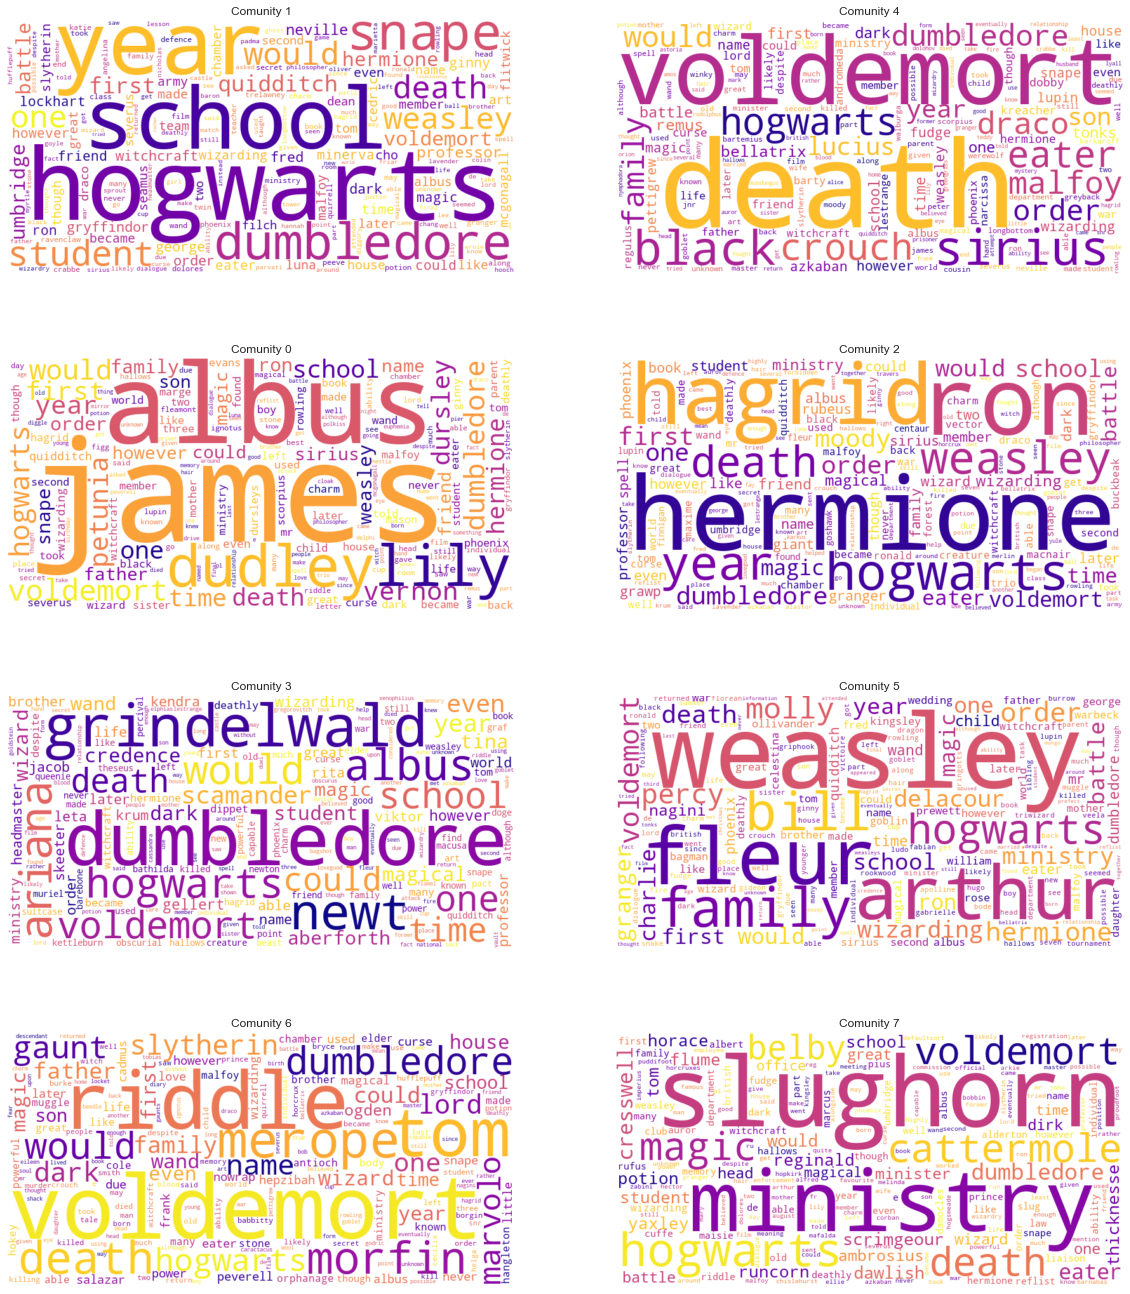

In [210]:
# Generate a single figure
plt.figure(figsize=(20,30))

for idx, community_number in enumerate(wordclouds):
    plt.subplot(5, 2, idx+1);
    plt.imshow(wordclouds[community_number], interpolation='bilinear');
    plt.title("Comunity %s" % community_number);
    plt.axis("off");

The wordclouds above represent the highest scoring words that are unique for each community in the network. It's clear that these words could be more revealing, but here are a few findings from them:
0. A community that seems to revolve around Harry's family. Albus is the name of Harry's son, and James is the name of his father. Lily is his mother, and Dudley, Vernon and Dursley represent his Muggle family.
1. This community seems to be a subcommunity at Hogwarts. It has to do with school, and perhaps a particular year at school.
2. Hagrid, Ron and Hermione's community. Beyond this, not much is notable.
3. A community that seems to revolve around Albus Dumbledore, Grindelwald, and perhaps some events that occur beyond the Harry Potter books.
4. A community that seems to revolve around death eaters. Lord Voldemort is a common phrase here, along with the Malfoys. Interestingly, Sirius Black seems to be involved with this community.
5. Most probably a Weasly family community. Charlie, Percy, Arthur are notable here.
6. A Voldemort community. Tom and Riddle are very notable, with "Marvolo" being Voldemort's middle-name. 'Gaunt', 'dark' and 'death' are common here.
7. Most probably a Ministry of Magic community. 

Let's explore which are the top nodes in the communities:

In [211]:
# Finding the top characters in these communities, and storing them by centrality

# Create a dataframe to store the results
df = pd.DataFrame(data=top_10_communities, columns=['Community number'])

# Find the top characters for each community
characters = []

# Find all the centralities of every node
centralities = nx.degree_centrality(G_GCC) 

for community_number in top_10_communities:
    # Find the centralities of the nodes in the community
    centralities_in_community = [(node, centralities[node]) for (node,data) in G_GCC.nodes(data=True) if data.get("community") == community_number]
    # Find the top characters and their centralities
    top_characters_centralities = dict(sorted(centralities_in_community, key=lambda x: x[1], reverse=True)[:10])
    # Find the names of the top values
    top_characters = list(top_characters_centralities.keys())
    characters.append(top_characters)
df['Top characters based on degree centrality'] = characters

with pd.option_context('display.max_colwidth', None):
  display(df)


Community number  \
0                 1   
1                 4   
2                 0   
3                 2   
4                 3   
5                 5   
6                 6   
7                 7   

                                                                                                                                     Top characters based on degree centrality  
0         [Severus Snape, Dolores Umbridge, Ginevra Weasley, Neville Longbottom, Minerva McGonagall, Luna Lovegood, Fred Weasley, George Weasley, Dean Thomas, Cedric Diggory]  
1  [Sirius Black, Draco Malfoy, Bellatrix Lestrange, Lucius Malfoy, Remus Lupin, Nymphadora Tonks, Cornelius Fudge, Peter Pettigrew, Bartemius Crouch Junior, Narcissa Malfoy]  
2              [Harry Potter, Lily J. Potter, Albus Potter, James Potter I, James Potter II, Dudley Dursley, Vernon Dursley, Petunia Dursley, Sturgis Podmore, Dedalus Diggle]  
3                                    [Ronald Weasley, Hermione Granger, Rubeus Hagrid, Alastor Moody, Travers, Walden Macnair, Olympe Maxime, Grawp, Selwyn, Marlene McKinnon]  
4       [Albus Dumbledore, Rita Skeeter, Viktor Krum, Aberforth Dumbledore, Gellert Grindelwald, Elphias Doge, Muriel, Xenophilius Lovegood, Armando Dippet, Bathilda Bagshot]  
5     [Arthur Weasley, Molly Weasley, William Weasley, Fleur Delacour, Percy Weasley, Kingsley Shacklebolt, Charles Weasley, Nagini, Garrick Ollivander, Rose Granger-Weasley]  
6                        [Tom Riddle, Salazar Slytherin, Tom Riddle Senior, Frank Bryce, Merope Riddle, Morfin Gaunt, Marvolo Gaunt, Tom, Godric Gryffindor, Helga Hufflepuff]  
7     [Horace Slughorn, Rufus Scrimgeour, Corban Yaxley, Pius Thicknesse, Dirk Cresswell, John Dawlish, Albert Runcorn, Mary Cattermole, Reginald Cattermole, Mafalda Hopkirk]

The findings outlined for the word clouds seem to be largely correct. Interestingly, Salazar Slytherin, Godric Gryffindor and Helga Huffelpuff are in the same community as Voldemort (6).

Let's name the communities by their 3 most connected characters...

In [173]:
community_nodes = {} # node as key and value as community
community_included = {} # community as key and all nodes as value
for com in set(list(communities.values())):
    nodes_in_com = [k for k,v in communities.items() if v == com] # group all nodes with same community
    most_connected = sorted(G_GCC.degree(nodes_in_com), key=lambda x: x[1], reverse=True) # most connected nodes
    name_length = 0 # initialize the name length
    name = '' 
    node_count = len(most_connected)
    # create the name, take care if there 

    while name_length < 3 and name_length < node_count:
        if name_length > 0 and name_length < 3:
            name += "|" + most_connected[name_length][0]
        else:
            name += most_connected[name_length][0]
        name_length += 1
    
    # Go through all the nodes in the community and set the 3 most connected characters as name
    for node in nodes_in_com:
        community_nodes[node] = name
        
    community_included[name] = nodes_in_com # put the newly created name
    
nx.set_node_attributes(G, community_nodes, "community")

And we can plot them:

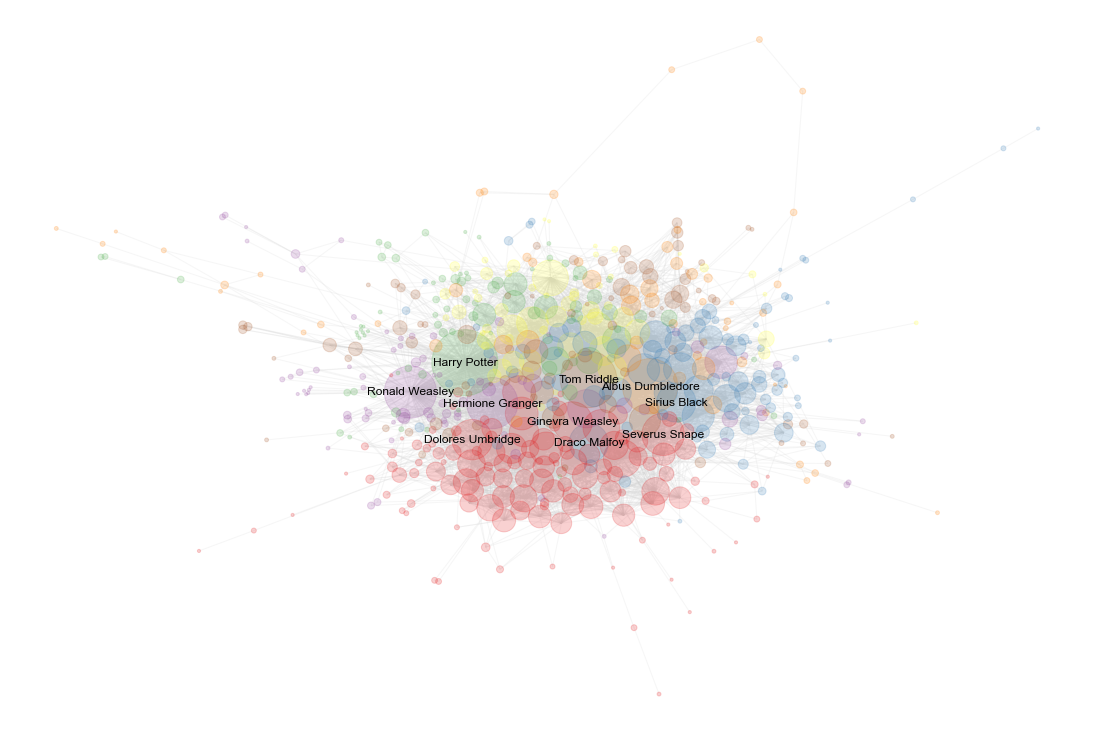

In [184]:
# Finally lets plot these results on the undirected version of the graph - NOTE HERE WE USE UNDIRECTED FOR PLOTTING
cmap = mtpl.cm.get_cmap('Set1', 10) # create 10 colors to use for plotting

colors = []

for i in range(cmap.N):
    rgb = cmap(i)[:3] # will return rgba, we take only first 3 so we get rgb
    colors.append(mtpl.colors.rgb2hex(rgb))


plt.figure(figsize=(15,10))

positions = forceatlas2.forceatlas2_networkx_layout(G_GCC, pos=None, iterations=2000)

# Generate sizes based on node centrality
node_sizes = list(nx.degree_centrality(G_GCC).values())
node_sizes = [round(num,3) for num in node_sizes]
node_sizes = [num*5000 for num in node_sizes]

# Lets try only coloring in the 10 biggest communities - other minor communities will be gray
# Otherwise it gets to confusing
node_colors = [colors[top_10_communities.index(m)] if (m in top_10_communities) else '#808080' for m in lovain_communities]

# Generate the graph
nx.draw(G_GCC, positions, with_labels = False, node_size = node_sizes, 
        node_color = node_colors, edge_color = 'lightgray', alpha=0.2);

# Generate the labels
labels = {}    
for node in G_GCC.nodes():
    if node in top_nodes[:10]:
        #set the node name as the key and the label as its value 
        labels[node] = node

# Now draw only the labels of the top nodes
nx.draw_networkx_labels(G_GCC, positions, labels, font_size=12, font_color='black');

The figure above shows the GCC of individuals, coloured by their communities. Harry, Hermione and Ron are close to each other as often, with Ginny and Draco being closer to Voldemort. 

Note that the colours tend to cluster together, with red being a big community at the bottom (Hogwarts subcommunity).

In [185]:
# Let's create the plot again with hubs being present

forceatlas3 = ForceAtlas2(
    # Behavior alternatives
    outboundAttractionDistribution = True, # Persuade hubs
    edgeWeightInfluence=1,
    
    # Performance
    jitterTolerance=0.7, # Tolerance
    barnesHutOptimize=True,
    barnesHutTheta=0.6,
    
    # Tuning
    scalingRatio=5.0,
    strongGravityMode=True,
    gravity=50.0,
    
    # Log
    verbose=False
)

positions3 = forceatlas3.forceatlas2_networkx_layout(G_GCC, pos=None, iterations=2000)

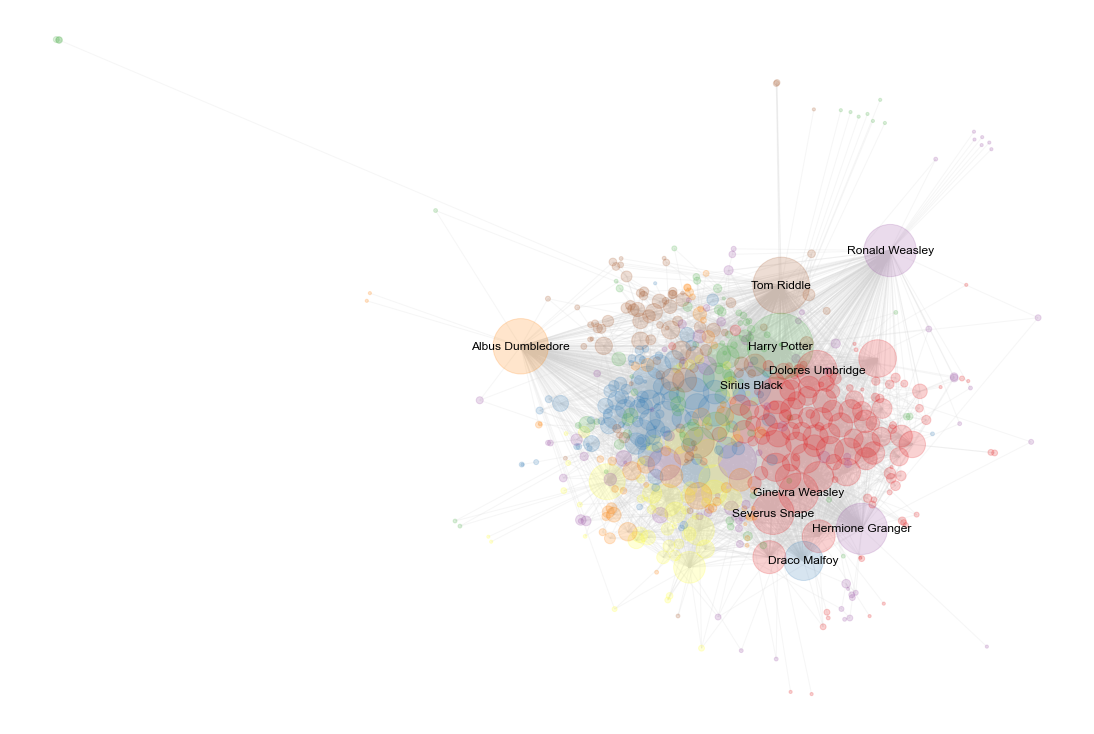

In [186]:
# Generate the graph again

plt.figure(figsize=(15,10))

nx.draw(G_GCC, positions3, with_labels = False, node_size = node_sizes, 
        node_color = node_colors, edge_color = 'lightgray', alpha=0.2);

# Now draw only the labels of the top nodes
nx.draw_networkx_labels(G_GCC, positions3, labels, font_size=12, font_color='black');


Another way to plot the above figure. Here, Tom Riddle and Harry Potter are closeby one another, and Harry is between a lot of communities.

In [176]:
# Let's save these results in a new graph

#with open(os.getcwd() + '/WikiNetwork/networks/individuals_with_communities.pkl', 'wb') as f:
#    pickle.dump(G, f)

### 3.1.3. Outcome

The community detection seems to have worked, but could have worked better. The different communities always seem to have some odd-out characters that don't feel like they belong there. Take for instance Sirius Black in the same community as Draco Malfoy and Bellatrix Lestrange. This might be our lack of domain knowledge, but the community seems to be fairly ill-willed, while Sirius is one of the 'good' guys. 

The reasons for the shortcomings of the community detection could be that the network is too interconnected. Too many nodes connect to too many other nodes, and as we only had the GCC to work with here, that left the algorithm little modularity to work with. So we will attribute this result to the nature of the network. One further note is that Harry Potter seemed to switch communities a lot. This indicated that his connectedness could tip the algorithm either way, between community A or B. Our thought is that a hierarchy-based community algorithm might be more suited here, where one individual can be part of many communities. This was not explored here, however.

As for the wordclouds, the TF-IDF analysis also had some issues. It appears that the wiki text of the nodes are not very distinct, and as such, the wordclouds do not reveal all too distinct results. This could be a matter of tweaking the calculation, applying another IDF-measure, or something similar, but we did not manage to improve the results. 

Overall, the analysis revealed that the network is not as easily defined as we might have hoped. Some shortcomings in the methods applied are of course possible, but it is probable that the network does not allow for much clearer results.



---

<a id='3-1-4-networksentiments'></a>
### 3.1.4 Wiki page sentiment analysis

Although the prior analysis (TF-IDF, specifically) seemed to indicate that the words in the Wiki text are not revealing enough, or too general, we are here going to analyze its content. More specifically, the goal of this analysis is to analyse its sentiment. Using a provided [word list](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0026752) from the course. The word list has been part of sentiment research, but any such list would do for this analysis. Sadly, no list specific for the Harry Potter universe was found when we searched. It's important to note that when doing a measurement like this, the outcome heavily relies on the tools. This being said, we have gotten decent results with the same wordlist before and assume that it is a fairly reliable metric for sentiment on lemmatized words. 

The method is fairly simple: For each character, we calculate the average word sentiment for each words that have a score attributed to it in the wordlist. Here we are going to analyse the sentimental value of the characters' WikiPages and, by extension, the communities found in the previous chapter.

In [187]:
# Declaring a map for the sentimental words we have access to

sentiments = {}
with open(os.getcwd() + '/WikiNetwork/data/Data_Set_S1.txt', 'r') as f:
    reader = csv.reader(f, dialect='excel-tab')
    for row in reader:
        if len(row) == 8 and row[0] != "word": # skipping the first lines
            sentiments[row[0].lower()] = float(row[2]) # storing the average sentiment

Now we have to declare a function to calculate the sentiment of a page

In [188]:
# Function to return sentiment

def sentiment(freqdist ,cut_off=False):
    sentim_words = [w for w in freqdist.keys() if sentiments.get(w)] # get all word that are in sentiment list
    sentim_values = [sentiments[val]*freqdist[val] for val in sentim_words] # get the value and multiplay by frequency
    sentim_words_freq = sum([freqdist[w] for w in sentim_words]) # total occurances of all valid sentim words
    if cut_off:
        if sentim_words_freq > cut_off: # only take in words that have certin frequency of sentimental words
            return sum(sentim_values) / sentim_words_freq
        else: 
            return False
    else:
        if len(sentim_words) > 0:
            return sum(sentim_values) / sentim_words_freq
        else: 
            return False

The sentiment function is computed for all of the Wiki pages and stored as an attribute called sentiment, for all the nodes in the giant component of the Wiki graph.

In [189]:
# Declaring maps to store the sentiments
pages_sentiment = {}
node_sentiment = {}

for node in cleaned_pages:
    sentiment_for_page = sentiment(nltk.FreqDist(cleaned_pages[node]))
    if sentiment_for_page:
        pages_sentiment[node] = sentiment_for_page
    if node in G.nodes():
        node_sentiment[node] = sentiment_for_page

# add the sentiment as attribute to the nodes 
nx.set_node_attributes(G, node_sentiment, "sentiment")

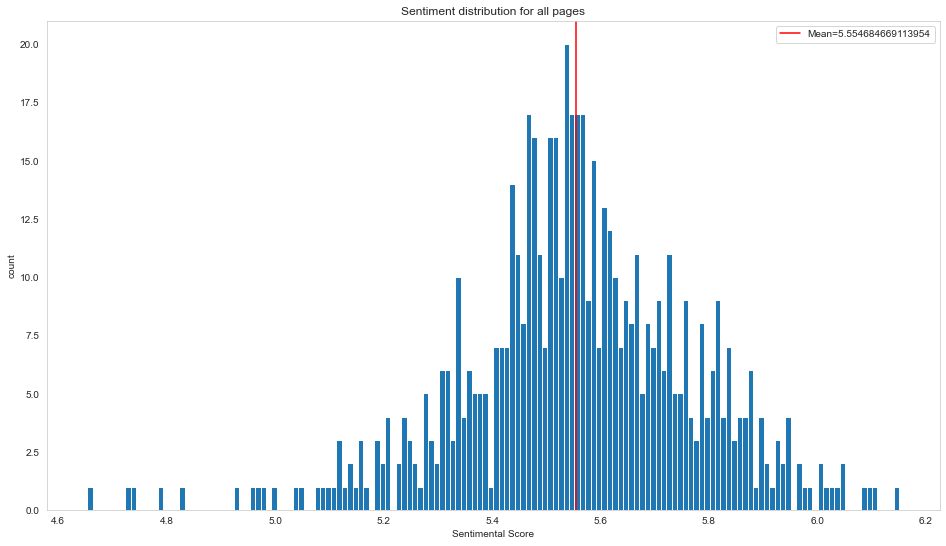

In [190]:
#Create a histogram of all character's associated page-sentiments.

plt.figure(figsize=(16,9))
plt.hist(pages_sentiment.values(),bins=150)
sent_mean = mean(list(pages_sentiment.values()))
plt.axvline(x=sent_mean, label=f'Mean={sent_mean}', c='red')
plt.legend()
plt.title('Sentiment distribution for all pages')
plt.ylabel('count')
plt.xlabel('Sentimental Score')

plt.show()

The histogram above shows the frequencies of sentimental scores for WikiPages. It's apparent that the sentiment of the WikiPages is not too spread out. This this being said, there are notable outliers around the bottom, below 4.7. Similarly there are a fair few with sentiment over 6.

In [191]:
print("\nHappiest pages: ")
happy_charactes = pd.DataFrame(sorted(pages_sentiment.items(), reverse=True, key=lambda x: x[1])[:10], columns=["Page", "Sentiment"], index = range(1,11))
display(happy_charactes)

print("\nUnhappiest pages: ")
unhappy_characters = pd.DataFrame(sorted(pages_sentiment.items(), reverse=False, key=lambda x: x[1])[:10], columns=["Page", "Sentiment"], index = range(1,11))
display(unhappy_characters)


Happiest pages: 


Page  Sentiment
1                                   Apolline Delacour   6.150352
2                                     Muriel's mother   6.102034
3   Unidentified Ministry of Magic Wizard at the 1...   6.095273
4                                Oliver Wood's mother   6.081875
5                                   Maisie Cattermole   6.046047
6                                Rose Granger-Weasley   6.041431
7                                               Derek   6.035000
8                                    Ellie Cattermole   6.030000
9                                  Roger Davies' date   6.014571
10                                    Libatius Borage   6.006489


Unhappiest pages: 


Page  Sentiment
1   Unidentified Committee for the Disposal of Dan...   4.653659
2                                              Gibbon   4.730138
3                                              Jugson   4.734981
4                                              Wilkes   4.793086
5                                 Urquhart Rackharrow   4.832174
6                                      Thorfinn Rowle   4.926401
7                                     Hedwig's killer   4.958054
8                                        Warty Harris   4.964800
9                          Montgomery sisters' mother   4.973659
10            Unidentified goblin killed by Voldemort   5.000152

The above tables show the top 10 happiest and top 10 saddest wikipages and their sentimental score.

These characters are fairly minor - let's apply a minimum degree to the nodes and try again

In [197]:
# Taking a copy of the pages sentiment list to try again
min_degree = 100

high_degree_sentiments = {}

for page in pages_sentiment:
    if G.degree[page] >= min_degree:
        high_degree_sentiments[page] = G.nodes[page]['sentiment']
        
print("\nHappiest (high degree) pages: ")
happy_charactes = pd.DataFrame(sorted(high_degree_sentiments.items(), reverse=True, key=lambda x: x[1])[:5], columns=["Page", "Sentiment"], index = range(1,6))
display(happy_charactes)

print("\nUnhappiest (high degree) pages: ")
unhappy_characters = pd.DataFrame(sorted(high_degree_sentiments.items(), reverse=False, key=lambda x: x[1])[:5], columns=["Page", "Sentiment"], index = range(1,6))
display(unhappy_characters)


Happiest (high degree) pages: 


Page  Sentiment
1   Fleur Delacour   5.663958
2  Horace Slughorn   5.660692
3   George Weasley   5.575152
4  Ginevra Weasley   5.570413
5    Molly Weasley   5.562165


Unhappiest (high degree) pages: 


Page  Sentiment
1  Bellatrix Lestrange   5.290920
2        Alastor Moody   5.334693
3           Tom Riddle   5.413001
4      Cornelius Fudge   5.422455
5     Dolores Umbridge   5.427364

The tables above show the happiest 5 and unhappiest 5 WikiPages in the network, disregarding all nodes that do not have a degree of at least 100. The idea is that these are supposed to be widely known / main characters. Note that Tom Riddle sits in the 3rd unhappiest place, with Weasleys populating 3 out of the top 5 happiest pages. Bellatrix Lestrange, Alastor Moody are villains, and Fleur Delacour is a student that visits Hogwarts. These results do certainly make sense.

In [113]:
# Finally, let's explore some pages and their sentimental values:

pages_to_test = ['Harry Potter', 'Tom Riddle', 'Rubeus Hagrid', 'Dobby', 'Lucius Malfoy']
pages_with_score = []
for page in pages_to_test:
    pages_with_score.append([page, G.nodes[page]['sentiment']])

pages_with_score = [n for n in sorted(pages_with_score, key=lambda x: x[1], reverse=True)]

print("Test pages by sentimental score (descending):\n")

for page in pages_with_score:
    print(page)

Test pages by sentimental score (descending):

['Rubeus Hagrid', 5.497308676734085]
['Dobby', 5.491567135793068]
['Harry Potter', 5.4706338939197785]
['Lucius Malfoy', 5.432224375121096]
['Tom Riddle', 5.41300101923811]


We've seen that the sentimental scoring works fairly well for the individuals in the network. Let's see how it fairs for whole communities! 

The idea is simple: Use the same idea as previously, but average the scores over the whole communities that they reside in.

In [198]:
average_community_sent = {}

for com in list(community_included.keys()):
    total_sent = 0
    total_nodes = 0
    if len(community_included[com]) > 1: # remove communities that only have one node
        for node in community_included[com]:
            if pages_sentiment.get(node):
                total_nodes += 1
                total_sent += pages_sentiment[node]
        avg_cent = total_sent/total_nodes
        average_community_sent[com] = avg_cent

In [199]:
print("\nCommunities and their average happiness: ")
comms_by_happiness = pd.DataFrame(sorted(average_community_sent.items(), reverse=True, key=lambda x: x[1])[:8], columns=["Community", "Sentiment"], index = range(1,9))
display(comms_by_happiness)


Communities and their average happiness: 


Community  Sentiment
1  Horace Slughorn|Rufus Scrimgeour|Corban Yaxley   5.648658
2    Arthur Weasley|Molly Weasley|William Weasley   5.626286
3        Harry Potter|Lily J. Potter|Albus Potter   5.614143
4       Albus Dumbledore|Rita Skeeter|Viktor Krum   5.608920
5  Severus Snape|Dolores Umbridge|Ginevra Weasley   5.547005
6  Tom Riddle|Salazar Slytherin|Tom Riddle Senior   5.515931
7   Ronald Weasley|Hermione Granger|Rubeus Hagrid   5.486878
8   Sirius Black|Draco Malfoy|Bellatrix Lestrange   5.474829

The table above shows the names of the communities along with their sentimental average, ordered by the value. The Weasley community sits happily in second place, with Harry and his family third. Voldemort, along with all the legends in his community sit in 6th place, and surprisingly Ron, Hermione and Hagrid are in 7th. This could have to do with the creatures that they meet on their travels. In last place is the community with Draco Malfoy, Bellatrix Lestrange, and, perhaps unfittingly, Sirius Black.

### 3.1.4. Outcome

The sentiment analysis made intuitive sense. The highest rated versus the lowest rated characters clearly shows a trend of the 'good' guys being happier than the 'bad' guys. Furthermore, the Weasly family seems to be doing quite well when it comes to sentiment. It's possible that the calculation was thrown off a bit by very short pages or very long pages. Note that when comparing the main characters, each character's sentimental score was not too far off the others. This is probably on account of the sheer length of the WikiText associated with the characters.

When it comes to the community sentimental analysis, it could make more sense. This is probably on account of the community split being somewhat less than intuitive at times.

---

<a id='3-1-5-interactivenetwork'></a>
### 3.1.5 (Bonus) Interactive wiki network

We desired to make an interactive version of the network, but found no suitable way to do it for a while. Then we stumbled accross the package [WebWeb](https://webwebpage.github.io/) for Python. It's a custom tool for creating and plotting networks, and has native support for NetworkX. As such, we wanted to give this a go for our website. This chapter is dedicated to the creation of the WikiPage network visible on our site. The goal is to have an intuitive and nice-looking visualisation running on a webpage.

One challenge we faced here was that there were too many attributes associated with the nodes to reasonably plot. A lot of the code you see here is dedicated to recreating the network without the undesired attributes. Additionally, we wanted to be able to change the node size by degree centrality, in-degree centrality or out-degree centrality. This is why we added these measures as an attribute to the network. These measures can be read up on in [this](https://www.geeksforgeeks.org/network-centrality-measures-in-a-graph-using-networkx-python/) brief summary. 

In [379]:
# Loading the Graph we have already

with open(hd + '/WikiNetwork/networks/individuals_with_communities.pkl', 'rb') as f:
    G_viz = pickle.load(f)
    
print("Loaded network of type {}, containing {} nodes and {} edges.".format(type(G_viz), len(G_viz), len(G_viz.edges)))

Loaded network of type <class 'networkx.classes.digraph.DiGraph'>, containing 626 nodes and 7371 edges.


In [380]:
# Building a copy of the network 

G = nx.DiGraph()

# Looping through other network and adding to the network
for node in G_viz.nodes:
    try:
        int(G_viz.nodes[node]['community'])
    except:
                
        G.add_node(node, # node name
                    book_nr = str(G_viz.nodes[node]['book_nr']), 
                    house = G_viz.nodes[node]['house'], 
                    sentiment = node_sentiment[node],
                    degree_centrality = nx.degree_centrality(G_viz)[node],
                    in_degree_centrality = nx.in_degree_centrality(G_viz)[node],
                    out_degree_centrality = nx.out_degree_centrality(G_viz)[node],
                    blood = G_viz.nodes[node]['blood'],
                    gender = G_viz.nodes[node]['gender'],
                    hair = G_viz.nodes[node]['hair'],
                    eyes = G_viz.nodes[node]['eyes'],
                    species = G_viz.nodes[node]['species'],
                    nationality = G_viz.nodes[node]['nationality'],
                    community = G_viz.nodes[node]['community']
                   )
    
for node in G.nodes:
    for link in G_viz.nodes[node]['links']:
        if link in G: # If other entity is in the network
            G.add_edge(node, link)
            

print("Added {} nodes. Size of network: {}".format(len(df_wiki), len(G)))  
print("{} edges in network.".format(len(G.edges)))

Added 788 nodes. Size of network: 587
7365 edges in network.


In [381]:
# Declaring smaller network only for those with Hogwarts houses:

nodes_with_houses = [node for node in G.nodes if G.nodes[node]['house'] != 'Unknown']


G_houses = G.subgraph(nodes_with_houses)
G_houses = G.subgraph(max(nx.weakly_connected_components(G_houses), key=len)) # Taking GCC for plotting

In [382]:
# Building another copy of the network, to leave out a few attributes that don't plot very well

G_comms = nx.DiGraph()

# Looping through other network and adding to the network
for node in G.nodes:             
    G_comms.add_node(node, # node name
                book_nr = str(G_viz.nodes[node]['book_nr']), 
                house = G_viz.nodes[node]['house'], 
                sentiment = node_sentiment[node],
                degree_centrality = G.nodes[node]['degree_centrality'],
                in_degree_centrality = G.nodes[node]['in_degree_centrality'],     
                out_degree_centrality = G.nodes[node]['out_degree_centrality'],     
                blood = G_viz.nodes[node]['blood'],
                gender = G_viz.nodes[node]['gender'],
                species = "Human" if G_viz.nodes[node]['species'] == "Human" else "Nonhuman",
                community = G_viz.nodes[node]['community'])

# Adding links
for node in G_comms.nodes:
    for link in G_viz.nodes[node]['links']:
        if link in G_comms: # If other entity is in the network
            G_comms.add_edge(node, link)
            

print("Added {} nodes. Size of network: {}".format(len(df_wiki), len(G)))  
print("{} edges in network.".format(len(G.edges)))


Added 788 nodes. Size of network: 587
7365 edges in network.


In [383]:
# Declaring webweb instance of the networks

web = Web(title='HogwartsHouseGCCNetwork', nx_G=G_houses)

web.networks.IndividualsCommunityNetwork(nx_G=G_comms)

In [384]:
# Configuration

web.display.colorBy = 'house'
web.display.sizeBy = 'degree'
web.display.gravity = .1
web.display.charge = 10
web.display.radius = 6
web.display.linkLength = 20
web.display.linkStrength = 0.1
web.display.colorPalette = 'RdYlGn'
web.display.scaleLinkOpacity = True
web.display.scaleLinkWidth = False
web.display.nameToMatch = 'Harry'

In [387]:
# Testing
web.show()

In [389]:
# Saving 

#web.save(hd + '/WikiNetwork/webweb_networks/final_webweb')

### 3.1.5. Outcome

We are very pleased with the outcome of this analysis. The interactive network is not only cool, it's a very intuitive way to explore the different attributes and how they spread over the network. For example, community, Hogwarts house and blood type seem to relate in ways that weren't necessarily noticeable or easily accessible with static visualizations.

<a id='6-2-wiki-cleaning'></a>
## 6.2 Fandom WikiPages - data fetching and cleaning



In [2]:
# Defining home directory
hd = os.getcwd()
print("Home directory set:")
print(hd)

Home directory set:
/Users/teddi/Documents/DTU/FALL2020/Social Graphs & Interactions/Git_pull_Dec2020/HarryPotter_02805_Project


### Setup and preperation for data fetching

After inspecting the Fandom API, we came up with the character indexes we wanted to fetch based on the books that characters (and other things) appear in. Here, the first step is to define the URLS used to fetch the data, and get the links that correspond to the characters that appear in those books. Some manual labour was required to make the right API calls, and to filter out those links that were not relevant.

In [3]:
# Creating a list of all the wikilinks of characters and another list of in which book each character appeared first
wikilinks = []
book_nrs = []

books = ['Harry_Potter_and_the_Philosopher%27s_Stone_(character_index)', 
'Harry_Potter_and_the_Chamber_of_Secrets_(character_index)', 
'Harry_Potter_and_the_Prisoner_of_Azkaban_(character_index)',
'Harry_Potter_and_the_Goblet_of_Fire_(character_index)',
'Harry_Potter_and_the_Order_of_the_Phoenix_(character_index)',
'Harry_Potter_and_the_Half-Blood_Prince_(character_index)',
'Harry_Potter_and_the_Deathly_Hallows_(character_index)']

for book in books:

    # Get characters from each book
    baseurl = 'https://harrypotter.fandom.com/api.php?action=query&prop=revisions&rvprop=content&rvslots=main&format=json&utf8=1&titles='
    wikiresponse_list = urllib2.urlopen(baseurl+book) # generate the complete query url
    wikihtml_list = wikiresponse_list.read().decode("utf-8") # Decode the results
    wikijson = json.loads(wikihtml_list) # Load the json 

    # Fetching the book text from json
    text = wikijson['query']['pages'][next(iter(wikijson['query']['pages']))]['revisions'][0]['slots']['main']['*']

    # Extracting all the links from the text
    links = re.findall(r"\[\[(.*?)\]\]", text)
    
    # Cleaning the links
    links_clean = [l.split('|')[0] for l in links if l.startswith(('File', 'nl:', 'Category:', 'pl:', 'ru:', 'Harry Potter and the ')) == False]
    
    # Determining book number
    book_nr = [books.index(book)+1 for i in range(len(set(links_clean)))]
    
    # Adding indication which book the character first appeared in
    wikilinks.extend(set(links_clean))
    book_nrs.extend(book_nr)

The resulting pages were then inserted to a DataFrame and duplicates were dropped.

In [4]:
# Creating a dataframe for wikis and their respective book numbers

df_wiki = pd.DataFrame(list(zip(wikilinks,book_nrs)), columns=['wiki','book'])
print("Dataframe length before dropping duplicates: {}".format(len(df_wiki)))

# We have a few duplicates that we need to drop. 
# We like to keep the first instance where the characters appeared
df_wiki = df_wiki.drop_duplicates(subset=['wiki'], keep='first')
print("Dataframe length after dropping duplicates: {}".format(len(df_wiki)))

Dataframe length before dropping duplicates: 810
Dataframe length after dropping duplicates: 789


### Fetching WikiPages

Now that the dataframe was set up, we fetched the pages from the Fandom API. We also had to handle redirects and make sure we were storing the correct data. The pages are stored in their respective book's folders (book1 - book7), as text files. 

Here, the folder structure of the project was heavily utilised, with each WikiPage stored in a .txt file within a respective 'book' folder. The reason this cell takes a while to run is because it needs to call the API for each character in our dataframe.

In terms of fetching the WikiPages, some error handling and regular expressions were used. Most notably, redirects were handled in the loop by visiting the page being pointed to, and alternative WikiPages are caught and stored, if applicable.

In [5]:
# Defining the working directory

os.chdir(hd + "/Wikis")
wd = os.getcwd()

# Surpress warning message for SettingWithCopyWarning
pd.options.mode.chained_assignment = None

# Now we must loop through all the character wikis and download all of their text into files
folders = ['book1','book2','book3', 'book4', 'book5', 'book6', 'book7']
for folder in folders:
    if not os.path.exists(folder):
        os.mkdir(folder)
        
# Keep information about which links redirect -> 
# That way we can make sure the information is displayed as correctly as possible
df_wiki['alternative_wiki'] = None

for idx, row in df_wiki.iterrows():
    # Check if working directory is correct based on the next row - we want to save each character into their book's folder
    expected_path = wd + '/book' + str(row['book'])
    if os.getcwd() != expected_path:
        print("Setting working directory")
        print(expected_path)
        os.chdir(expected_path)

    # Get info about the character
    baseurl = 'https://harrypotter.fandom.com/api.php?action=query&prop=revisions&rvprop=content&rvslots=main&format=json&utf8=1&titles='
    title = urllib.parse.quote(row.wiki)
    file_name = row.wiki

    print("Book: ", row.book, " Character: ", row.wiki)

    wikiresponse = urllib2.urlopen(baseurl+title) # generate the complete query url
    wikihtml = wikiresponse.read().decode("utf-8") # Decode the results
    wikijson = json.loads(wikihtml) # Load the json 

    # Extract the page text from the json, these are located at different places 
    try:
        text = wikijson['query']['pages'][next(iter(wikijson['query']['pages']))]['revisions'][0]['slots']['main']['*']
    except:
        try:
            text = wikijson['query']['pages'][next(iter(wikijson['query']['pages']))]['revisions'][0]['*']
        except:
            if wikijson['query']['pages'][next(iter(wikijson['query']['pages']))]['missing'] == '':
                text = ''
   
    # Before we continue we must check if there is a redirect on the text - otherwise we will get no info on the character
    if text.startswith('#REDIRECT'):
        
        link = re.findall(r"\[\[(.*?)\]\]", text)
        new_title = urllib.parse.quote(link[0])
        print("WAS REDIRECTED TO: ", link[0])

        #Redo the steps above with the new_title
        wikiresponse = urllib2.urlopen(baseurl+new_title) # generate the complete query url
        wikihtml = wikiresponse.read().decode("utf-8") # Decode the results
        wikijson = json.loads(wikihtml) # Load the json

        try:
            text = wikijson['query']['pages'][next(iter(wikijson['query']['pages']))]['revisions'][0]['slots']['main']['*']
        except:
            try:
                text = wikijson['query']['pages'][next(iter(wikijson['query']['pages']))]['revisions'][0]['*']
            except:
                if wikijson['query']['pages'][next(iter(wikijson['query']['pages']))]['missing'] == '':
                    text = ''

        # Update the wiki redirects to
        df_wiki.at[idx, 'alternative_wiki'] = link[0]
        file_name = link[0]

    # Create a txt file of the text contained on the wikipage
    file = open(file_name + '.txt', "w") 
    file.write(text) 
    file.close() 

# going back to home directory
os.chdir(hd)

Setting working directory
/Users/teddi/Documents/DTU/FALL2020/Social Graphs & Interactions/Git_pull_Dec2020/HarryPotter_02805_Project/Wikis/book1
Book:  1  Character:  Battle in the Philosopher's Stone Chambers
WAS REDIRECTED TO:  Skirmish in the Underground Chambers
Book:  1  Character:  Adalbert Waffling
Book:  1  Character:  Norberta
Book:  1  Character:  Vernon Dursley's secretary
Book:  1  Character:  Quentin Trimble
Book:  1  Character:  Hogwarts Giant Squid
Book:  1  Character:  Baruffio
Book:  1  Character:  Sirius Black
Book:  1  Character:  Emeric Switch
Book:  1  Character:  King's Cross Station
Book:  1  Character:  Gregory the Smarmy
Book:  1  Character:  Garrick Ollivander
Book:  1  Character:  Angelina Johnson
Book:  1  Character:  Dudley Dursley's tortoise
Book:  1  Character:  Harry Potter
Book:  1  Character:  Lucius Malfoy
Book:  1  Character:  Poppy Pomfrey
Book:  1  Character:  McKinnon family
Book:  1  Character:  Hogwarts Express conductor
Book:  1  Character:  C

Book:  2  Character:  Ogden
Book:  2  Character:  Chudley Cannons
Book:  2  Character:  Transylvania
Book:  2  Character:  Veronica Smethley
Book:  2  Character:  Colin Creevey
Book:  2  Character:  Hetty Bayliss
Book:  2  Character:  Hogwarts Board of Governors
Book:  2  Character:  Fawkes
Book:  2  Character:  Salazar Slytherin
Book:  2  Character:  Fire Dwelling Salamander
Book:  2  Character:  Mason
Book:  2  Character:  Weasley family ghoul
Book:  2  Character:  Rowena Ravenclaw
Book:  2  Character:  Mason's wife
Book:  2  Character:  Hermione Granger's mother
Book:  2  Character:  Blood-Sucking Bugbear
Book:  2  Character:  Mosag
Book:  2  Character:  Manager of Flourish and Blotts
Book:  2  Character:  Mudblood
Book:  2  Character:  Bandon Banshee
Book:  2  Character:  Parseltongue
Book:  2  Character:  Godric Gryffindor
Book:  2  Character:  Tom Riddle's diary
WAS REDIRECTED TO:  T. M. Riddle's Diary
Book:  2  Character:  Yeti
Book:  2  Character:  Fawcett
Book:  2  Character: 

Book:  4  Character:  Ludovic Bagman's goblin creditors
Book:  4  Character:  Winky
Book:  4  Character:  Weird Sisters
Book:  4  Character:  Owen Cauldwell
Book:  4  Character:  Otto Bagman
Book:  4  Character:  Kevin
Book:  4  Character:  Unidentified female Chinese Fireball
Book:  4  Character:  Lee Jordan's father
Book:  4  Character:  Lev Zograf
Book:  4  Character:  Andorran Ministry of Magic
Book:  4  Character:  Alastor Moody
Book:  4  Character:  Alice Longbottom
Book:  4  Character:  Dennis Creevey
Book:  4  Character:  Thomas Riddle
Book:  4  Character:  Summers
Book:  4  Character:  Ogg
Book:  4  Character:  Aberforth Dumbledore
Book:  4  Character:  Mulciber (Marauder-era)
WAS REDIRECTED TO:  Mulciber II
Book:  4  Character:  Vasily Dimitrov
Book:  4  Character:  Bartemius Crouch Junior
Book:  4  Character:  Igor Karkaroff
Book:  4  Character:  Bodrod the Bearded
Book:  4  Character:  Cornelius Fudge's wife
Book:  4  Character:  Dot
Book:  4  Character:  Bartemius Crouch J

Book:  6  Character:  Amy Benson
Book:  6  Character:  Sanguini
Book:  6  Character:  Mulciber (Riddle-era)
WAS REDIRECTED TO:  Mulciber I
Book:  6  Character:  Morfin Gaunt
Book:  6  Character:  Montgomery sisters
Book:  6  Character:  Caractacus Burke
Book:  6  Character:  Eric Whalley
Book:  6  Character:  Katie Bell's father
Book:  6  Character:  Eloise Midgen's father
Book:  6  Character:  Corban Yaxley
Book:  6  Character:  Chancellor of the Exchequer
Book:  6  Character:  Rupert Brookstanton
Book:  6  Character:  Rosalind Bungs
Book:  6  Character:  Cormac McLaggen
Book:  6  Character:  Romilda Vane
Book:  6  Character:  Unidentified nine-year old's grandparents
Book:  6  Character:  Avery (Riddle-era)
WAS REDIRECTED TO:  Avery I
Book:  6  Character:  Horace Slughorn
Book:  6  Character:  Urquhart
Book:  6  Character:  Wilkie Twycross
Book:  6  Character:  Prime Minister's niece
Book:  6  Character:  Damocles Belby
Book:  6  Character:  Alecto Carrow
Book:  6  Character:  Dirk C

In [6]:
# Showing how the dataframe looks now
df_wiki.head(3)

wiki  book  \
0  Battle in the Philosopher's Stone Chambers     1   
1                           Adalbert Waffling     1   
2                                    Norberta     1   

                       alternative_wiki  
0  Skirmish in the Underground Chambers  
1                                  None  
2                                  None

Here, checking on alternative wikis is necessary. Let's see which are in the dataframe:

In [7]:
# If the redirect links already exist in the dataframe we need to drop them

alternative_wikis = set(list(df_wiki.alternative_wiki))
df_wiki[df_wiki.wiki.isin(alternative_wikis)]

wiki  book alternative_wiki
417  Alastor Moody     4             None

In [8]:
# Seems like Alastor Moody is also Alastor "Mad-Eye" Moody in the data

# So we override the alternative_wiki link for this row 
df_wiki[df_wiki.wiki == 'Alastor Moody']['alternative_wiki'] = 'Alastor "Mad-Eye" Moody'

#Finally we drop the row containing 'Alastor "Mad-Eye" Moody' in the wiki
df_wiki = df_wiki[df_wiki.wiki != 'Alastor "Mad-Eye" Moody']

If we were to overwrite the already existing data with this fetch we would run the following cell, but to avoid this we leave it commented:

In [9]:
# Switching back to Wikis folder
#os.chdir(hd + "/Wikis")

# Creating a new folder to store the dataframe and switching to it:
#if not os.path.exists("dataframes"):
#    os.mkdir("dataframes")
#os.chdir(hd + "/dataframes")

# And fetching the files is done, saving the dataframe:
#with open('original_wiki_df.pkl', 'wb') as f:
#    pickle.dump(df_wiki, f)

### Cleaning and sorting WikiPages

Now that all the files were downloaded, we needed to extract the valuable information out of them. This was a crucial step to be able to construct a network out of the data. 

We started by loading the original dataframe created by the steps above, as we wanted to avoid overwriting it. A new, cleaned dataframe will be created and stored.

In [10]:
# Start by fetching the dataframe from above and changing the directory:

os.chdir(hd + "/Wikis")

# Fetching the original dataframe

with open('dataframes/original_wiki_df.pkl', 'rb') as f:
    df_wiki = pickle.load(f)

Now, we looped through the DataFrame that contained information about the WikiPages, and opened the files that corresponded with the rows. Then, we fetched the links that were contained in the page, and various attributes such as the Hogwarts House, family and others.

This part required a lot of regular expression, template searching and cleaning. After a lot of work, a consistent method to extract page type, Hogwarts house etc. was found, and used to store data on the page. When extracting the templates to access the test, the Python package [MyParserFromHell](https://pypi.org/project/mwparserfromhell/) came in particularly handy.

In [11]:
# Now we need to loop through all the files and extract information to add to the dataframe

# Surpress warning message for SettingWithCopyWarning
pd.options.mode.chained_assignment = None

folders = ['book1','book2','book3', 'book4', 'book5', 'book6', 'book7']

# Define the working directory
wd = hd + ("/Wikis")

# Add columns to the dataframe for the additional information
df_wiki['text'] = None
df_wiki['links'] = None
df_wiki['house'] = "Unknown"
df_wiki['type'] = "Unknown"
df_wiki['blood'] = "Unknown"
df_wiki['nationality'] = "Unknown"
df_wiki['gender'] = "Unknown"
df_wiki['hair'] = "Unknown"
df_wiki['eyes'] = "Unknown"
df_wiki['species'] = "Unknown"


# Definitions for later
wiki_links = list(df_wiki.wiki)
alternative_links = list(df_wiki.alternative_wiki[df_wiki.alternative_wiki.notna()])
all_wiki_links = wiki_links + alternative_links

for idx, row in df_wiki.iterrows():
    # Check if working directory is correct based on the next row - we want to save each character into their book's folder
    expected_path = wd + '/book' + str(row['book'])
    if os.getcwd() != expected_path:
        print("Setting working directory")
        print(expected_path)
        os.chdir(expected_path)

    # Check if there was an alternative link for this character
    file_name = row.wiki
    if row.alternative_wiki != None:
        file_name = row.alternative_wiki

    # Opening the file containing the WikiPage
    file = open(file_name + '.txt', "r") 
    text = file.read()
    file.close() 

    # Print info so easier to see where loop is running
    #print("Book: ", row.book, " Character: ", file_name)

    # Finding the links in the entity's WikiPage
    links = re.findall(r"\[\[(.*?)\]\]", text)
    links_clean = [l.split('|')[0] for l in links if l.startswith(('File', 'nl:', 'Category:', 'pl:', 'ru:', 'Harry Potter and the ')) == False]
    
    # filter all the links based on characters in the dataframe
    wiki_links_clean = [l for l in links_clean if l in wiki_links]
    alternative_links_clean = [l for l in links_clean if l in alternative_links]

    # Clean up and overwrite link values where there are alternative wikis
    for i in range(len(alternative_links_clean)):
        alternative_links_clean[i] = df_wiki[df_wiki.alternative_wiki==alternative_links_clean[i]].wiki.item()

    # Combine both links into a single set
    clean_links = list(set(wiki_links_clean + alternative_links_clean))

    # Storing the WikiPage text and its links in the DataFrame
    df_wiki.at[idx, "text"] = text
    df_wiki.at[idx, "links"] = clean_links

    # We also want to extract more information from the text of each character.
    # Source for info: https://github.com/earwig/mwparserfromhell
    wikicode = mwparserfromhell.parse(text) # Convert to wikicode
    templates = wikicode.filter_templates() # Extract the templates of the wikicode

    # Checking whether the WikiPage is for an individual
    if len([t for t in templates if t.startswith('{{Individual infobox')]) > 0:
        
        # If the WikiPage is for an individual, we can start fetching information about the individual
        template = [t for t in templates if t.startswith('{{Individual infobox')][0] # Find the template containing the infobox

        # Extract the relevant information from the template
        if template.has_param('blood'):
            blood = re.findall(r"\[\[(.*?)\]\]", str(template.get('blood').value))

        if template.has_param('nationality'):
            nationality = re.findall(r"\[\[(.*?)\]\]", str(template.get('nationality').value))
            nationality = [n.split('|')[0] for n in nationality]

        if template.has_param('species'):
            species = re.findall(r"\[\[(.*?)\]\]", str(template.get('species').value))

        if template.has_param('gender'):
            gender = [template.get('gender').value.strip().split('<')[0]]

        if template.has_param('hair'):
            hair = [template.get('hair').value.strip().split('<')[0]]

        if template.has_param('eyes'):
            eyes = [template.get('eyes').value.strip().split('<')[0]]
  
        if template.has_param('house'):
            house = re.findall(r"\[\[(.*?)\]\]", str(template.get('house').value))
            
        # Write the relevant values into the dataframe
        if len(nationality) > 0:
            df_wiki.at[idx, "nationality"] = nationality[0]

        if len(species) > 0:
            if species[0] and species[0]:
                df_wiki.at[idx, "species"] = species[0]
            
        if len(gender) > 0:
            if gender[0] != "":
                df_wiki.at[idx, "gender"] = gender[0]
            
        if len(hair) > 0:
            if hair[0] != "":
                df_wiki.at[idx, "hair"] = hair[0]
            
        if len(eyes) > 0:
            if eyes[0] != "":            
                df_wiki.at[idx, "eyes"] = eyes[0]
                        
        if len(house) > 0:
            df_wiki.at[idx, "house"] = house[0]
            
        if len(blood) > 0:
            df_wiki.at[idx, "blood"] = blood
        
        # Finally, we're declaring the character as an individual
        df_wiki.at[idx, "type"] = "Individual"
    

    # If the WikiPage is not for an individual, here we store what type the entity is    
    elif len([t for t in templates if t.startswith('{{Object infobox')]) > 0:
        df_wiki.at[idx, "type"] = "Object"
        
    elif len([t for t in templates if t.startswith('{{Pet individual infobox')]) > 0:
        df_wiki.at[idx, "type"] = "Pet"
        
    elif len([t for t in templates if t.startswith('{{Creature infobox')]) > 0:
        df_wiki.at[idx, "type"] = "Creature"
        
    elif len([t for t in templates if t.startswith('{{Letter_infobox')]) > 0:
        df_wiki.at[idx, "type"] = "Letter"      

    elif len([t for t in templates if t.startswith('{{Family infobox')]) > 0:
        df_wiki.at[idx, "type"] = "Family"      

    elif len([t for t in templates if t.startswith('{{Location infobox')]) > 0:
        df_wiki.at[idx, "type"] = "Location"
        
    elif len([t for t in templates if t.startswith('{{Battle infobox')]) > 0:
        df_wiki.at[idx, "type"] = "Battle" 

    elif len([t for t in templates if t.startswith('{{Quidditch Team infobox')]) > 0:
        df_wiki.at[idx, "type"] = "Quidditch Team" 
        
    elif len([t for t in templates if t.startswith('{{Organisation infobox')]) > 0:
        df_wiki.at[idx, "type"] = "Organisation" 
        
    elif len([t for t in templates if t.startswith('{{Potion infobox')]) > 0:
        df_wiki.at[idx, "type"] = "Potion" 
        
    elif len([t for t in templates if t.startswith('{{Plant infobox')]) > 0:
        df_wiki.at[idx, "type"] = "Plant" 
        
    elif len([t for t in templates if t.startswith('{{Spell infobox')]) > 0:
        df_wiki.at[idx, "type"] = "Spell" 
    
    elif len([t for t in templates if t.startswith('{{Event infobox')]) > 0:
        df_wiki.at[idx, "type"] = "Event" 
        
    elif len([t for t in templates if t.startswith('{{Official post')]) > 0:
        df_wiki.at[idx, "type"] = "Official post" 
        
    elif len([t for t in templates if t.startswith('{{School infobox')]) > 0 or len([t for t in templates if t.startswith('{{School_infobox')]) > 0:
        df_wiki.at[idx, "type"] = "School" 
        
    elif len([t for t in templates if t.startswith('{{Horcrux infobox')]) > 0:
        df_wiki.at[idx, "type"] = "Horcrux" 
        
    elif len([t for t in templates if t.startswith('{{Class infobox')]) > 0:
        df_wiki.at[idx, "type"] = "Class" 
        
    elif len([t for t in templates if t.startswith('{{Book infobox')]) > 0:
        df_wiki.at[idx, "type"] = "Book" 
        
    else:
        df_wiki.at[idx, "type"] = "Unknown"
    
# reset wd
os.chdir(wd)


Setting working directory
/Users/teddi/Documents/DTU/FALL2020/Social Graphs & Interactions/Git_pull_Dec2020/HarryPotter_02805_Project/Wikis/book1
Setting working directory
/Users/teddi/Documents/DTU/FALL2020/Social Graphs & Interactions/Git_pull_Dec2020/HarryPotter_02805_Project/Wikis/book2
Setting working directory
/Users/teddi/Documents/DTU/FALL2020/Social Graphs & Interactions/Git_pull_Dec2020/HarryPotter_02805_Project/Wikis/book3
Setting working directory
/Users/teddi/Documents/DTU/FALL2020/Social Graphs & Interactions/Git_pull_Dec2020/HarryPotter_02805_Project/Wikis/book4
Setting working directory
/Users/teddi/Documents/DTU/FALL2020/Social Graphs & Interactions/Git_pull_Dec2020/HarryPotter_02805_Project/Wikis/book5
Setting working directory
/Users/teddi/Documents/DTU/FALL2020/Social Graphs & Interactions/Git_pull_Dec2020/HarryPotter_02805_Project/Wikis/book6
Setting working directory
/Users/teddi/Documents/DTU/FALL2020/Social Graphs & Interactions/Git_pull_Dec2020/HarryPotter_0280

Now that every page was saved with appropriate attributes, cleaning was needed on the attributes:

**Blood**: For this part, a decision had to be made. Take for example Pius Thicknesse:

In [12]:
df_wiki[df_wiki.wiki == 'Pius Thicknesse']

wiki  book alternative_wiki  \
805  Pius Thicknesse     7             None   

                                                  text  \
805  {{FA}}\n{{Individual infobox\n|theme = mom\n|i...   

                                                 links    house        type  \
805  [Diagon Alley, Amycus Carrow, Rufus Scrimgeour...  Unknown  Individual   

                        blood    nationality gender              hair  \
805  [Pure-blood, half-blood]  Great Britain   Male  Black and silver   

        eyes species  
805  Unknown   Human

Their blood type is set as both Pure-blood and half-blood. This sort of mess was true throughout the dataframe, and as such the following decision was made for simplicity: 

Half blood took the highest priority, pure-blood the second, muggles third and muggle-born last. This was on account of likelihood of the different attributes (there are not many muggle-born, for example). We tried prioritizing pure-bloods, but that resulted in far too many of them (mislabelings).

In [13]:
for idx, row in df_wiki.iterrows():
    if row.blood:
        blood = [x.lower() for x in row.blood]
        if 'half-blood' in blood:
            df_wiki.at[idx, 'blood'] = "Half-Blood"
        elif 'pure-blood' in blood:
            df_wiki.at[idx, 'blood'] = "Pure-Blood"
        elif 'non-magic people|muggle' in blood:
            df_wiki.at[idx, 'blood'] = "Muggle"
        elif 'muggle-born' in blood:
            df_wiki.at[idx, 'blood'] = "Muggle-Born"
        else:
            df_wiki.at[idx, 'blood'] = "Unknown"
    else:
        df_wiki.at[idx, 'blood'] = "Unknown"

In [14]:
df_wiki[df_wiki.wiki == 'Pius Thicknesse']

wiki  book alternative_wiki  \
805  Pius Thicknesse     7             None   

                                                  text  \
805  {{FA}}\n{{Individual infobox\n|theme = mom\n|i...   

                                                 links    house        type  \
805  [Diagon Alley, Amycus Carrow, Rufus Scrimgeour...  Unknown  Individual   

          blood    nationality gender              hair     eyes species  
805  Half-Blood  Great Britain   Male  Black and silver  Unknown   Human

As can be seen above, Pius is now Half-blood.

In [15]:
# Cleaning eyes attribute

for idx, row in df_wiki.iterrows():
    if row.eyes:
        eyes = row.eyes.lower()
        if 'blue' in eyes:
            df_wiki.at[idx, 'eyes'] = "Blue"
        if 'pale' in eyes:
            df_wiki.at[idx, 'eyes'] = "Pale"
        if 'green' in eyes:
            df_wiki.at[idx, 'eyes'] = "Green"            
        if 'brown' in eyes:
            df_wiki.at[idx, 'eyes'] = "Brown"
        if 'dark' in eyes:
            df_wiki.at[idx, 'eyes'] = "Dark"   
        if 'yellow' in eyes:
            df_wiki.at[idx, 'eyes'] = "Yellow"
        if 'gimlet' in eyes:
            df_wiki.at[idx, 'eyes'] = "Unknown"            
    else:
        df_wiki.at[idx, 'eyes'] = "Unknown"

**Hair**: Cleaning hair attribute:

In [16]:
# Cleaning hair attribute

for idx, row in df_wiki.iterrows():
    if row.hair:
        hair = row.hair.lower()
        if 'dark' in hair:
            df_wiki.at[idx, 'hair'] = "Dark" 
        if 'blonde' in hair or 'blond' in hair:
            df_wiki.at[idx, 'hair'] = "Blonde" 
        if 'bald' in hair:
            df_wiki.at[idx, 'hair'] = "Bald" 
        if 'red' in hair:
            df_wiki.at[idx, 'hair'] = "Red" 
        if 'black' in hair:
            df_wiki.at[idx, 'hair'] = "Black" 
        if 'brown' in hair:
            df_wiki.at[idx, 'hair'] = "Brown" 
        if 'grey' in hair or 'silver' in hair:
            df_wiki.at[idx, 'hair'] = "Grey" 
        if 'ginger' in hair:
            df_wiki.at[idx, 'hair'] = "Red" 
        if 'fair' in hair or 'white' in hair:
            df_wiki.at[idx, 'hair'] = "White" 
        if 'unknown' in hair:
            df_wiki.at[idx, 'hair'] = "Unknown" 
    else:
        df_wiki.at[idx, 'hair'] = "Unknown"

**Gender**: Cleaning gender attribute:

In [17]:
# Cleaning gender attribute

for idx, row in df_wiki.iterrows():
    if row.gender:
        gender = row.gender.lower()
        if 'female' in gender:
            df_wiki.at[idx, 'gender'] = "Female"
        else:
            df_wiki.at[idx, 'gender'] = "Male"
    else:
        df_wiki.at[idx, 'gender'] = "Unknown"

**Species**: Cleaning species attribute:

In [18]:
# Cleaning species attribute

for idx, row in df_wiki.iterrows():
    if row.species:
        species = row.species.lower()
        if 'house-elf' in species:
            df_wiki.at[idx, 'species'] = "House-elf"
        if 'veela' in species:
            df_wiki.at[idx, 'species'] = "Veela"
        if 'human' in species:
            df_wiki.at[idx, 'species'] = "Human"

    else:
        df_wiki.at[idx, 'gender'] = "Unknown"

**Nationality**: Cleaning nationality attribute:

In [19]:
# Cleaning nationality attribute

for idx, row in df_wiki.iterrows():
    if row.nationality:
        nationality = row.nationality.lower()
        if '1994' in nationality:
            df_wiki.at[idx, 'nationality'] = "Unknown"
    else:
        df_wiki.at[idx, 'nationality'] = "Unknown"

In [20]:
df_wiki.head(2)

wiki  book alternative_wiki  \
0             Tufty     1             None   
1  Mirror of Erised     1             None   

                                                text  \
0  {{Pet individual infobox\n|image = \n|name = T...   
1  {{Spoiler|PAS|WU}}\n{{Object infobox\n|name = ...   

                                               links    house    type  \
0  [Dudley Dursley, Mr Tibbles, Harry Potter, Sno...  Unknown     Pet   
1  [Aberforth Dumbledore, Boggart, Gregory Goyle,...  Unknown  Object   

     blood nationality gender     hair     eyes  species  
0  Unknown     Unknown   Male  Unknown  Unknown  Unknown  
1  Unknown     Unknown   Male  Unknown  Unknown  Unknown

**Great!**

### Cleaning WikiPage text

Now that the individual attributes have been cleaned, it was time to clean the text for further analysis later. 

This is done largely using the awesome [Natural Language Toolkit (NLTK)](https://www.nltk.org/) package for Python, with some help from the package [BeautifulSoup](https://pypi.org/project/beautifulsoup4/) as well. Each word is cleaned for line breaks, English stop words (as well as manual stopwords), tokens are extracted, the words are lemmatized and then joined back together. This is done in the preprocessing stage to avoid this work in the actual network analyses. 

In [21]:
# Create a lemmatization object to use and stopwords
stopwords = nltk.corpus.stopwords.words('english')
manual_stopwords = ["category", "file", "also", "http"]

wnl = nltk.WordNetLemmatizer()

# Getting all rows in our dataframe
all_pages = df_wiki['wiki'].tolist()

In [22]:
# Looping through the dataframe and applying the techniques to each row

for page in all_pages:
    # Extracting text
    raw_txt = df_wiki.loc[df_wiki['wiki'] == page, 'text'].values[0]
    
    # Parsing with BeautifulSoup
    bs4txt = BeautifulSoup(raw_txt, 'html.parser').get_text()
    
    # Replacing linebreaks and splitting / lowercasing
    bs4txt = bs4txt.replace("\n", "")
    bs4txt = bs4txt.split(" ")
    bs4txt = [w.lower() for w in bs4txt]
    
    # Filtering out some noise
    bs4txt = [w if not "*" in w
              and not "|" in w
              and not "category" in w
              and not "file" in w
              and not "www" in w
              else "" 
              for w in bs4txt]
    
    bs4txt = " ".join(bs4txt)
    
    # Tokenizing
    tokens = word_tokenize(bs4txt) 
    
    # Skip punctuation 
    words = [w.lower() for w in tokens if w.isalpha()] 
    
    # Lemmatizing and skipping stopwords
    lem_words = [wnl.lemmatize(w) for w in words if w not in stopwords and w not in manual_stopwords] 
    
    # And joining the outcome
    final_text = " ".join(lem_words)
    
    # Updating the dataframe
    df_wiki.loc[df_wiki.wiki == page, "text"] = final_text

In [23]:
# Let's look at Harry's text now:

df_wiki.loc[df_wiki.wiki == "Harry Potter", "text"].values[0]

'harry potter book harry potter film series harry potter video game harry potter harry harry james july hollow west country england great tom riddle state strange likeness u even must noticed married pm dumbledore army reunites quidditch world cup final archived daily prophet july lied daily goyle known school year disguise weasley disguise polyjuice dudley made alias caught snatcher taking first name uncle cousin improvise runcorn disguise well look said malfoy usual lazy drawl pulling open compartment door potty time fine potty friend hearing voice seeing vision peeve blew gigantic raspberry hey potty heard warrington sworn knock broom wise move granger breathed malfoy new head new time good potty weasel potty asked loony go party potty lurves loony potty luuuuurves watching potty told harry indignantly pointing fight letting loud cackle peeve draco malfoy wee potty wee potter cackled peeve knocking harry glass askew bounced past potty wee potter cackled peeve mashingspoon harry pott

# Success!

_The different attributes are now stored in the dataframe, and we can start analysing the different entities fetched from the WikiPage._

**Storing this version of the DataFrame in case that's desired:**

In [31]:
# Creating a new folder to store the dataframe and switching to it:
#if not os.path.exists("dataframes"):
#    os.mkdir("dataframes")
#os.chdir(os.getcwd() + "/dataframes")

# And fetching the files is done, saving the dataframe:
#with open('cleaned_wiki_df.pkl', 'wb') as f:
#    pickle.dump(df_wiki, f)